In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

In [3]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


# Dataset Visualization

In [48]:
baseline_dataset_config = {
  "dataset": "color_mnist_add",
    "root_dir": "data/",
    "num_workers": 8,
    "batch_size": 2048,
    "num_operands": 5,
    "selected_digits": [3, 8],
    "count_labels": True,
    "low_noise_level": 1,
    "noise_level": 0.25,
    "test_low_noise_level": 1,
    "test_noise_level": 0.25,
    "train_dataset_size": 500,
    "test_dataset_size": 500,
    "sampling_percent": 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": False,
    "spurious_strength": 0.1,
    "color_by_label": False,
    "colors": ["random_1", "random_2", "random_3", "random_4", "random_5", "random_6", "random_7", "random_8", "random_9", "random_10"],
    "digit_color_distribution": {
      0: ["spurious", None, None, None, None, None, None, None, None, None],
      1: [None, "spurious", None, None, None, None, None, None, None, None],
      2: [None, None, "spurious", None, None, None, None, None, None, None],
      3: [None, None, None, "spurious", None, None, None, None, None, None],
      4: [None, None, None, None, "spurious", None, None, None, None, None],
      5: [None, None, None, None, None, "spurious", None, None, None, None],
      6: [None, None, None, None, None, None, "spurious", None, None, None],
      7: [None, None, None, None, None, None, None, "spurious", None, None],
      8: [None, None, None, None, None, None, None, None, "spurious", None],
      9: [None, None, None, None, None, None, None, None, None, "spurious"],
    },
    "test_digit_color_distribution": {
      0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      1: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      2: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      3: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      4: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      5: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      6: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      8: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      9: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    },
}

downstream_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
downstream_spurious_dataset_config['spurious_strength'] = 0.95
downstream_spurious_dataset_config['color_by_label'] = True

concept_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
concept_spurious_dataset_config['spurious_strength'] = 0.95
concept_spurious_dataset_config['color_by_label'] = False

ood_dataset_config = copy.deepcopy(baseline_dataset_config)
ood_dataset_config['test_noise_level'] = 0.5

In [49]:
import cem.utils.data as data_utils
import cem.data.color_mnist_add as color_mnist_data_module

n_samples = 5
for (dataset_config, name) in [
    (baseline_dataset_config, "baseline"),
    (downstream_spurious_dataset_config, "downstream spurious"),
    (concept_spurious_dataset_config, "concept spurious"),
    (ood_dataset_config, "OOD"),
]:
    train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
        color_mnist_data_module.generate_data(
            config=dataset_config,
            seed=42,
            output_dataset_vars=True,
            root_dir=dataset_config.get('root_dir', None),
        )
    x_train, y_train, c_train = data_utils.daloader_to_memory(train_dl)
    fig, axs = plt.subplots(1, 2*n_samples + 1, figsize=(32, 24), dpi=80)
    fig.suptitle(name.upper(), fontsize=80)
    for i in range(n_samples):
        axs[i].set_title(f"Train #{i+1}\nLabel: {y_train[i]}", fontsize=35)
        axs[i].imshow(x_train[i, :, :, :].transpose(1, 2, 0))
        axs[i].axis("off")
    x_test, y_test, c_test = data_utils.daloader_to_memory(test_dl)
    axs[n_samples].axis("off")
    for i in range(n_samples):
        axs[n_samples + 1 + i].set_title(f"Test #{i+1}\nLabel: {y_test[i]}", fontsize=35)
        axs[n_samples + 1 + i].imshow(x_test[i, :, :, :].transpose(1, 2, 0))
        axs[n_samples + 1 + i].axis("off")
    plt.axis(False)
    plt.show()
    print("-"*80)

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 42


KeyboardInterrupt: 

# Intervention Visualization on Complete MNIST Experiment

In [4]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/color_mnist_count/complete'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Joint CBM (Downstream Spurious)': 'CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Joint CBM (Concept Spurious)': 'CBM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_extra_dims_5_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Hybrid-CBM (Downstream Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Hybrid-CBM (Concept Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'CEM (Baseline)': 'CEM_emb_size_32_Noisy_Count_Baseline_20_cwl_10',
 'CEM (Downstream Spurious)': 'CEM_emb_size_32_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'CEM (Concept Spurious)': 'CEM_emb_size_16_Noisy_Count_Concept_Spurious_20_cwl_10',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Noisy_Count_Baseline_20_cwl_10',
 'IntCEM (Concept Spurious)': 'IntCEM_emb_size_8_intervention_weight_0

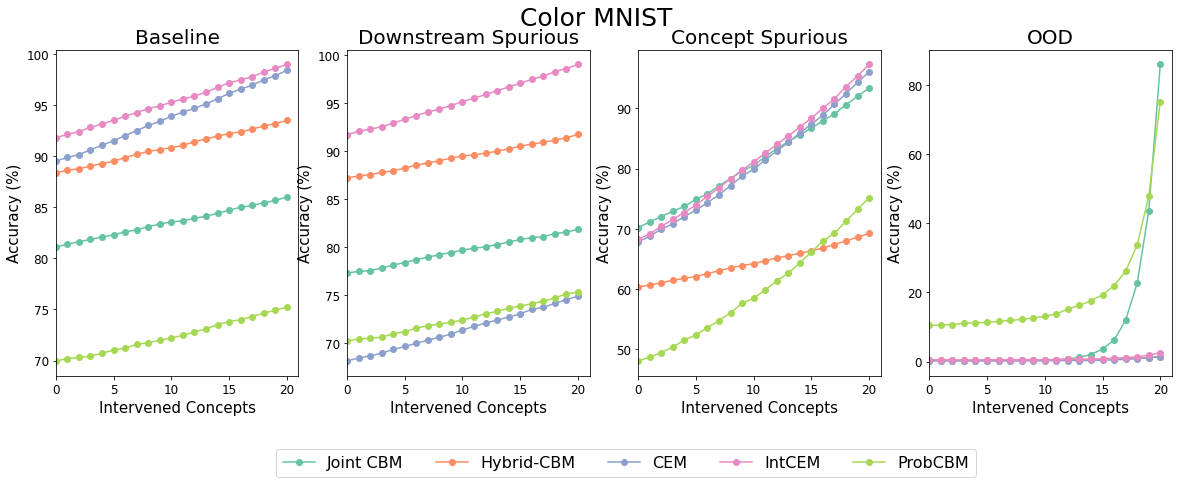

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, 21))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for ax, (mode_name, mode_key) in zip(
    axs,
    [
        ("Baseline", " (Baseline)"),
        ("Downstream Spurious", " (Downstream Spurious)"),
        ("Concept Spurious", " (Concept Spurious)"),
        ("OOD", " (Baseline)"),
    ]
):
    for idx, label in enumerate([
        "Joint CBM",
        "Hybrid-CBM",
        "CEM",
        "IntCEM",
        "ProbCBM",
    ]):
        model_name = selected_models.get(
            label + mode_key,
            label,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if mode_name == 'OOD' else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = clrs[idx]
        ax.plot(
            means,
            "-x" if "MixCEM" in label else "-o",
            color=color,
            label=label,
        )
        # ax.scatter(
        #     xticks,
        #     means,
        #     color=color,
        #     marker="x" if "MixCEM" in label else ".",
        # )
        # ax.fill_between(
        #     xticks,
        #     means - stds,
        #     means + stds,
        #     alpha=0.2,
        #     facecolor=color,
        # )
    ax.set_xlim(0, len(means))
    # ax.set_xticks(xticks)
    ax.set_ylabel("Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(mode_name, fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Color MNIST", fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=5,
)
plt.show()

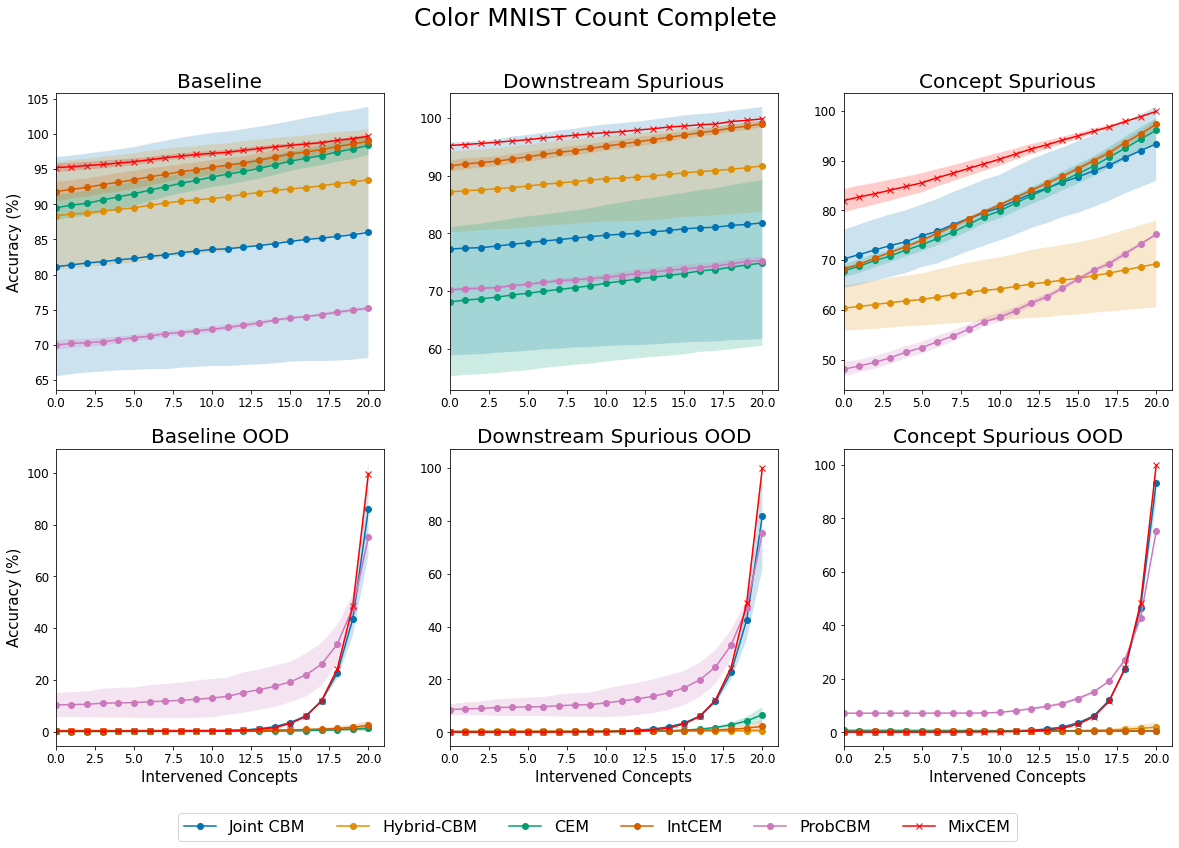

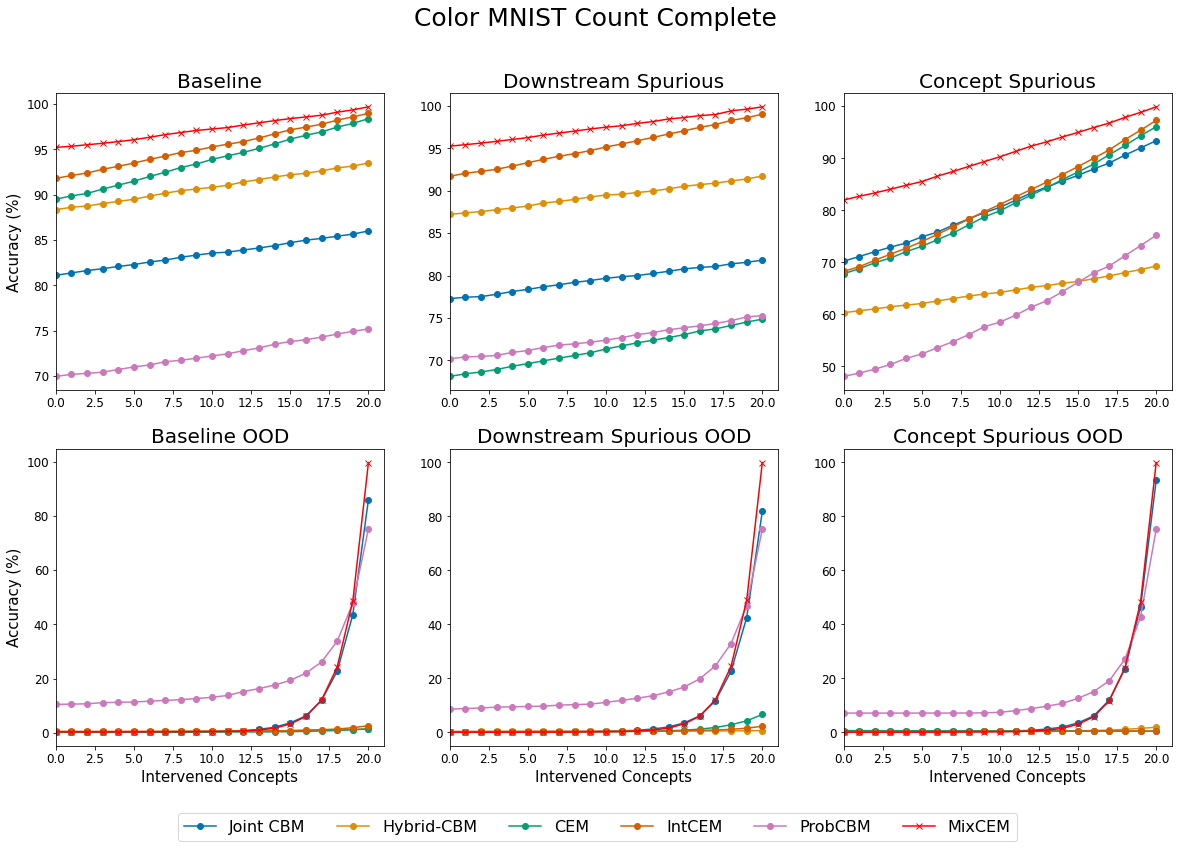

In [6]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 21))
rename_map = {
    # "Mixing-CEM": "MixCEM",
    # "ResidualMixing-CEM": "MixCEM (with intervention loss)",
    "ResidualMixing-CEM": "MixCEM",
}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Downstream Spurious", " (Downstream Spurious)", (0, 1)),
            ("Concept Spurious", " (Concept Spurious)", (0, 2)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
            ("Downstream Spurious OOD", " (Downstream Spurious)", (1, 1)),
            ("Concept Spurious OOD", " (Concept Spurious)", (1, 2)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "ResidualMixing-CEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Color MNIST Count Complete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(-0.75,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/color_mnist_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/color_mnist_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# 50% Incomplete Color MNIST Experiment

In [24]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/color_mnist_count/incomplete'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models


{'Joint CBM (Baseline)': 'CBM_Sigmoid_Noisy_Count_Baseline_20_cwl_1',
 'Joint CBM (Downstream Spurious)': 'CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_1',
 'Joint CBM (Concept Spurious)': 'CBM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Hybrid-CBM (Downstream Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Hybrid-CBM (Concept Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'CEM (Baseline)': 'CEM_emb_size_8_Noisy_Count_Baseline_20_cwl_10',
 'CEM (Downstream Spurious)': 'CEM_emb_size_32_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'CEM (Concept Spurious)': 'CEM_emb_size_32_Noisy_Count_Concept_Spurious_20_cwl_10',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Noisy_Count_Baseline_20_cwl_10',
 'IntCEM (Concept Spurious)': 'IntCEM_emb_size_8_intervention_weight_0.1_

label Joint CBM means [42.69333333 39.65333333 35.97333333 32.17333333 29.22666667 25.80666667
 23.18666667 20.90666667 19.07333333 17.20666667 16.01333333]
label Hybrid-CBM means [73.28666667 73.5        73.82666667 74.08666667 74.36666667 74.56
 74.86       75.12666667 75.28666667 75.54       75.72666667]
label CEM means [70.98666667 71.25333333 71.57333333 71.93333333 72.24666667 72.58
 72.84666667 73.16       73.53333333 73.94       74.26      ]
label IntCEM means [70.64       70.92       71.14       71.34       71.60666667 71.82
 72.2        72.48       72.80666667 73.14666667 73.36666667]
label ProbCBM means [22.62       22.66666667 22.80666667 22.87333333 23.06       23.21333333
 23.42       23.96       24.19333333 24.48666667 24.61333333]
label MixCEM means [74.97333333 74.96666667 75.09333333 75.11333333 75.13333333 75.18
 75.32666667 75.24666667 75.3        75.41333333 75.50666667]
label Joint CBM means [36.83333333 33.82666667 30.83333333 27.51333333 24.52666667 21.75333333


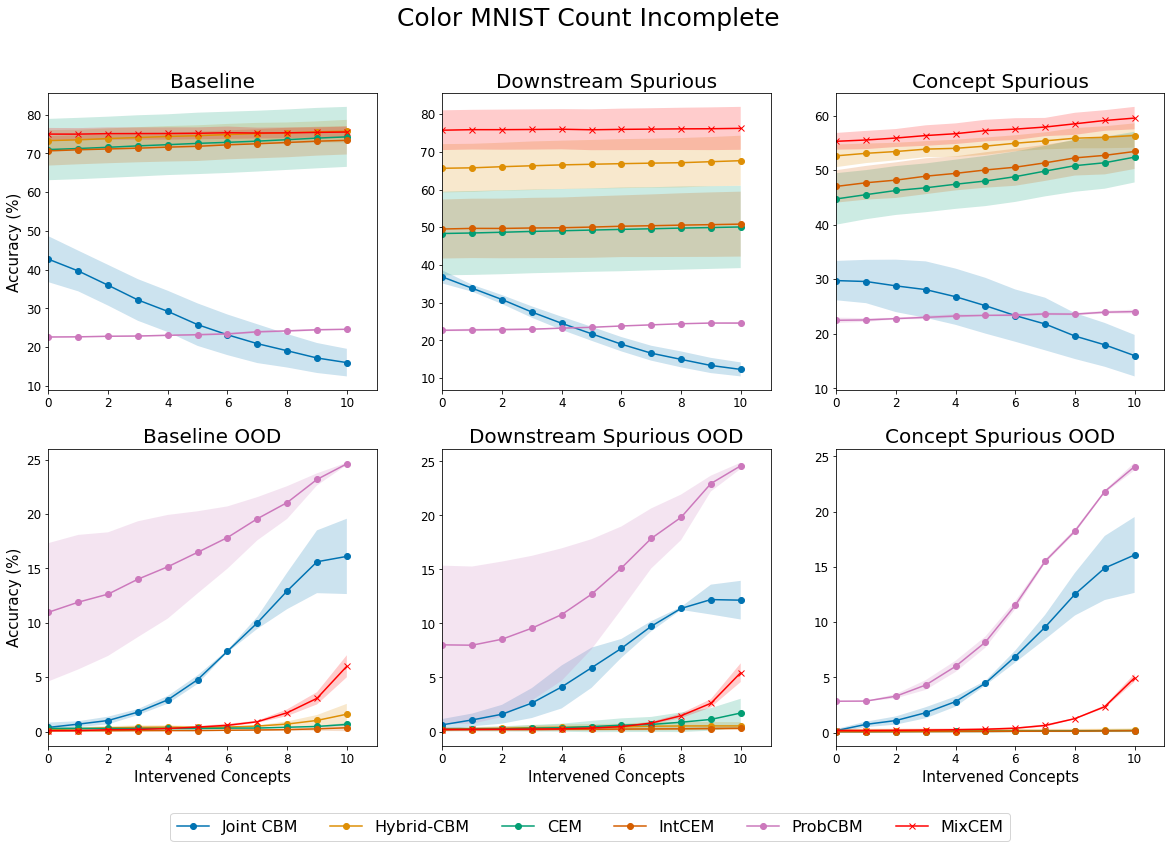

label Joint CBM means [42.69333333 39.65333333 35.97333333 32.17333333 29.22666667 25.80666667
 23.18666667 20.90666667 19.07333333 17.20666667 16.01333333]
label Hybrid-CBM means [73.28666667 73.5        73.82666667 74.08666667 74.36666667 74.56
 74.86       75.12666667 75.28666667 75.54       75.72666667]
label CEM means [70.98666667 71.25333333 71.57333333 71.93333333 72.24666667 72.58
 72.84666667 73.16       73.53333333 73.94       74.26      ]
label IntCEM means [70.64       70.92       71.14       71.34       71.60666667 71.82
 72.2        72.48       72.80666667 73.14666667 73.36666667]
label ProbCBM means [22.62       22.66666667 22.80666667 22.87333333 23.06       23.21333333
 23.42       23.96       24.19333333 24.48666667 24.61333333]
label MixCEM means [74.97333333 74.96666667 75.09333333 75.11333333 75.13333333 75.18
 75.32666667 75.24666667 75.3        75.41333333 75.50666667]
label Joint CBM means [36.83333333 33.82666667 30.83333333 27.51333333 24.52666667 21.75333333


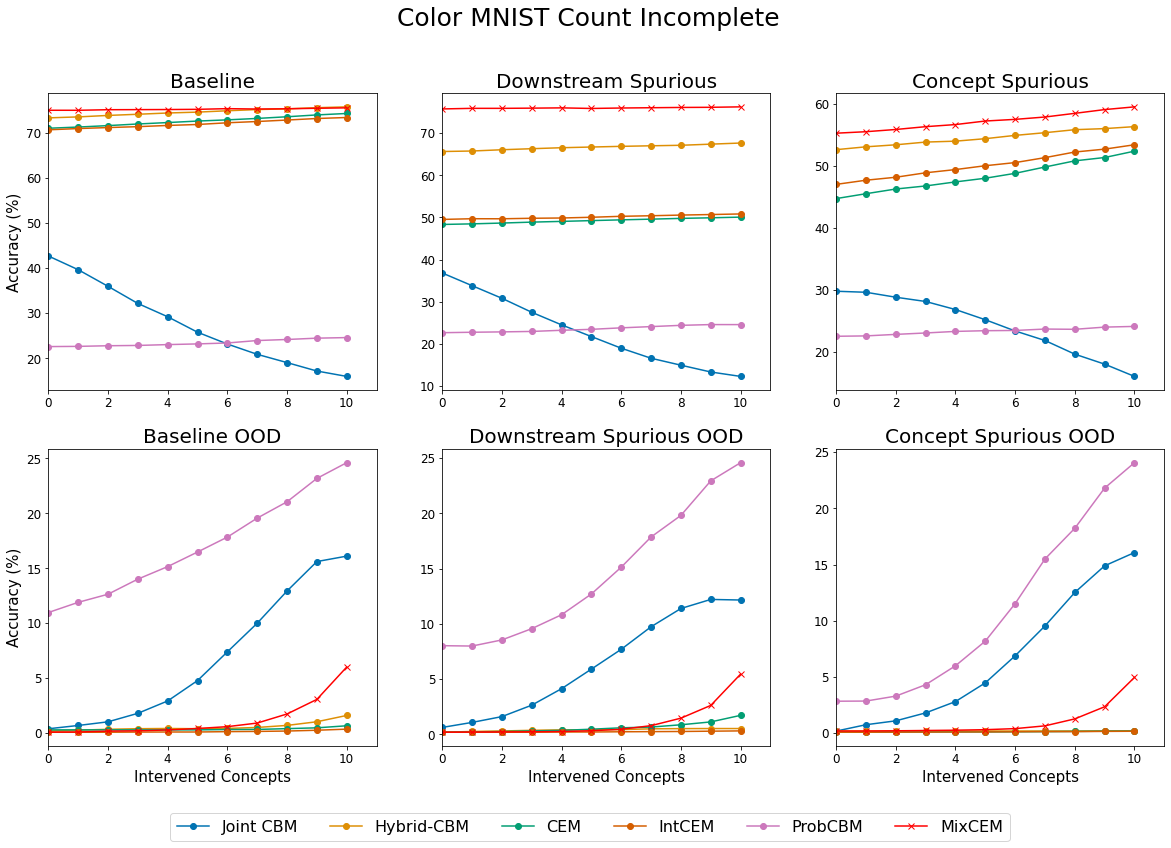

In [25]:

clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 11))
rename_map = {
    # "Mixing-CEM": "MixCEM",
    # "ResidualMixing-CEM": "MixCEM (with intervention loss)",
    "ResidualMixing-CEM": "MixCEM",
}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Downstream Spurious", " (Downstream Spurious)", (0, 1)),
            ("Concept Spurious", " (Concept Spurious)", (0, 2)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
            ("Downstream Spurious OOD", " (Downstream Spurious)", (1, 1)),
            ("Concept Spurious OOD", " (Concept Spurious)", (1, 2)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "ResidualMixing-CEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            print("label", label, "means", means)
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Color MNIST Count Incomplete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(-0.75,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/color_mnist_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/color_mnist_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# CUB Incomplete

In [4]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/cub_incomplete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1',
 'CEM (Baseline)': 'CEM_Baseline_cwl_1',
 'IntCEM (Baseline)': 'IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75',
 'Posthoc CBM (Baseline)': 'PCBM_reg_0.001_l1_0.99_penalty_1',
 'Hybrid Posthoc CBM (Baseline)': 'HybridPCBM_reg_0.1_l1_0.99_penalty_1',
 'Entropy CMCMixIntCEM No Calibration (Baseline)': 'Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1',
 'Entropy CMCMixIntCEM (Baseline)': 'Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1',
 'Entropy CMCMixCEM No Calibration (Baseline)': 'Entropy_CMCMixCEM_t_1_r_1_concat_None_0_m

Baseline Joint CBM means = [56.46070648 59.21643079 61.85134047 65.42400184 69.19226786 72.58658382
 76.35484984 79.57657347]
Baseline Hybrid-CBM means = [72.13209067 74.21470487 76.3145783  78.52951329 81.10689219 83.2642964
 85.42745369 87.54458635]
Baseline CEM means = [74.41606259 77.10274997 79.95627661 82.89034634 85.68058912 87.92428949
 89.98964446 92.07801174]
Baseline IntCEM means = [72.60959613 77.08549074 81.34852146 85.01898516 88.66643654 91.58324704
 94.02255207 96.07640087]
Baseline ProbCBM means = [60.55689794 63.68081924 67.50086296 71.79841215 76.32033138 80.55459671
 84.44943045 87.79772178]
Baseline MixIntCEM means = [73.80048326 78.54677252 83.12622253 87.02105627 90.40386607 93.01001036
 95.09837763 96.86457255]
Baseline MixCEM means = [74.39305028 79.1508457  83.64975262 87.31446324 90.43263146 92.90645495
 95.04084685 96.64020251]
Baseline OOD Joint CBM means = [ 0.50051778  1.60510873  4.35507997 10.80428029 21.45898055 37.83799333
 58.05430906 79.57657347]
Ba

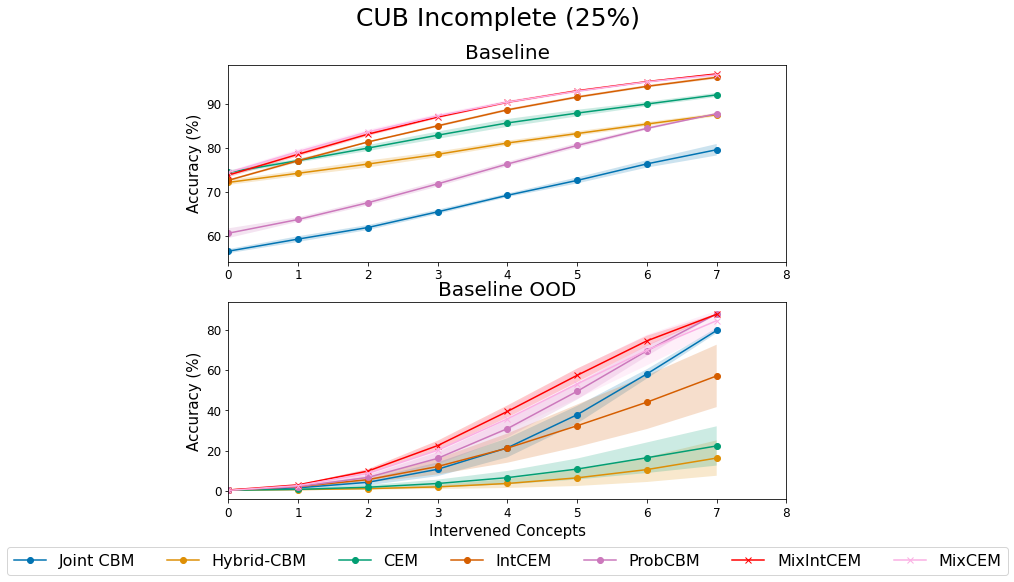

Baseline Joint CBM means = [56.46070648 59.21643079 61.85134047 65.42400184 69.19226786 72.58658382
 76.35484984 79.57657347]
Baseline Hybrid-CBM means = [72.13209067 74.21470487 76.3145783  78.52951329 81.10689219 83.2642964
 85.42745369 87.54458635]
Baseline CEM means = [74.41606259 77.10274997 79.95627661 82.89034634 85.68058912 87.92428949
 89.98964446 92.07801174]
Baseline IntCEM means = [72.60959613 77.08549074 81.34852146 85.01898516 88.66643654 91.58324704
 94.02255207 96.07640087]
Baseline ProbCBM means = [60.55689794 63.68081924 67.50086296 71.79841215 76.32033138 80.55459671
 84.44943045 87.79772178]
Baseline MixIntCEM means = [73.80048326 78.54677252 83.12622253 87.02105627 90.40386607 93.01001036
 95.09837763 96.86457255]
Baseline MixCEM means = [74.39305028 79.1508457  83.64975262 87.31446324 90.43263146 92.90645495
 95.04084685 96.64020251]
Baseline OOD Joint CBM means = [ 0.50051778  1.60510873  4.35507997 10.80428029 21.45898055 37.83799333
 58.05430906 79.57657347]
Ba

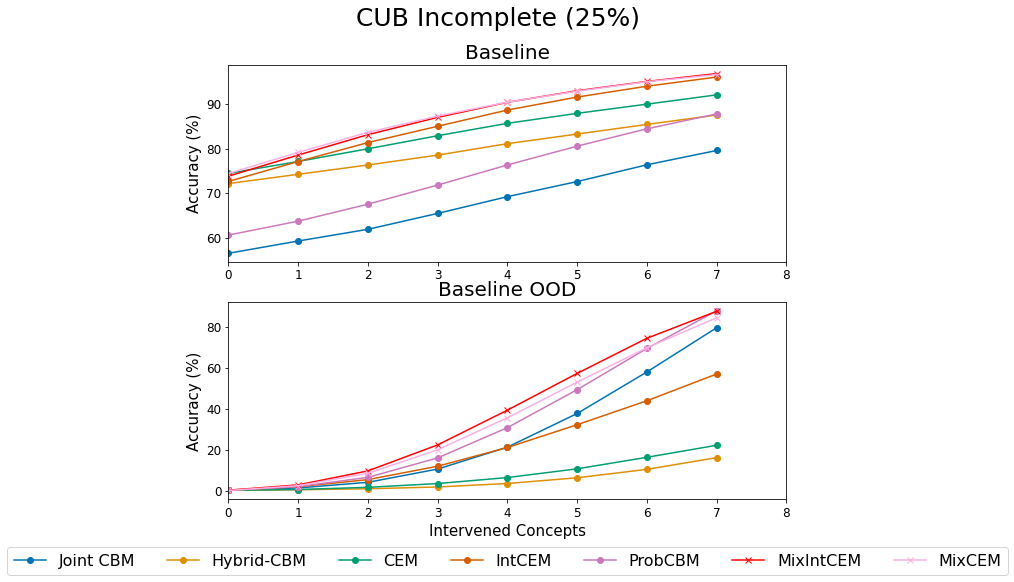

In [6]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 8))
rename_map = {"Entropy CMCMixIntCEM": "MixIntCEM", "Entropy CMCMixCEM": "MixCEM"}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "Entropy CMCMixIntCEM",
            "Entropy CMCMixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CUB Incomplete (25%)", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=7,
    )
    plt.savefig(f"../figures/cub_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/cub_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# CUB Complete

In [6]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/cub_complete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_10',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5',
 'CEM (Baseline)': 'CEM_Baseline_cwl_1',
 'IntCEM (Baseline)': 'IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1',
 'MixCEM (Baseline)': 'MixCEM_n_extra_50_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_256_ml_0_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75',
 'Posthoc CBM (Baseline)': 'PCBM_reg_1e-06_l1_0.99_penalty_1',
 'Posthoc Hybrid CBM (Baseline)': 'HybridPCBM_reg_1e-06_l1_0.99_penalty_1',
 'CMCMixIntCEM No Calibration (Baseline)': 'CMCMixIntCEM_freeze_all_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1',
 'CMCMixIntCEM (Baseline)': 'CMCMixIntCEM_freeze_all_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.

Baseline Joint CBM means = [70.96996893 72.22413991 73.76021171 75.27902428 76.87837993 78.59279715
 80.428029   82.14819929 83.93165343 85.68058912 87.36048786 89.13243585
 90.36359452 91.72132091 92.8431711  93.89598435 94.6381314  95.36301922
 95.89230238 96.3295363  96.57116557 96.85881947 97.14647336 97.27304108
 97.46864573 97.55494189 97.73328731 97.82533656 97.98066966]
Baseline Hybrid-CBM means = [73.65090323 74.7785065  75.7680359  77.02220688 78.16706938 79.50178345
 80.68116442 81.84903924 82.98814866 84.21930733 85.45621908 86.73340237
 88.03359797 89.23023818 90.35208837 91.42791393 92.50949258 93.39546657
 94.2469221  94.85674836 95.50109308 96.05338856 96.5654125  96.85881947
 97.10044874 97.34207801 97.60096652 97.85985502 98.06696583]
Baseline CEM means = [76.66551605 78.30514325 79.78943735 81.43481763 82.99390174 84.45518352
 85.95098378 87.30871016 88.44781958 89.52939823 90.67426073 91.72132091
 92.68783799 93.48751582 94.20089748 94.79921758 95.38027845 96.030376

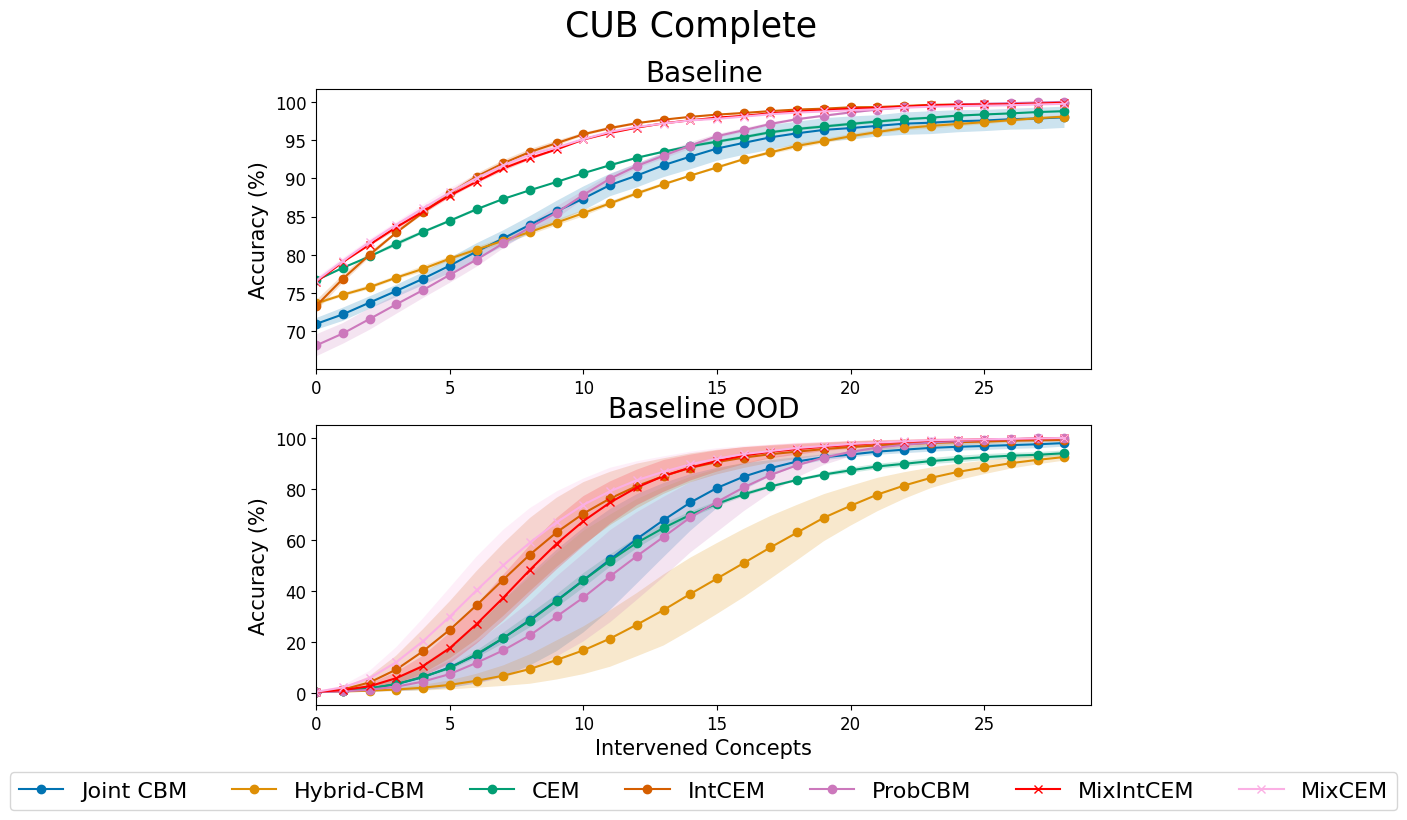

Baseline Joint CBM means = [70.96996893 72.22413991 73.76021171 75.27902428 76.87837993 78.59279715
 80.428029   82.14819929 83.93165343 85.68058912 87.36048786 89.13243585
 90.36359452 91.72132091 92.8431711  93.89598435 94.6381314  95.36301922
 95.89230238 96.3295363  96.57116557 96.85881947 97.14647336 97.27304108
 97.46864573 97.55494189 97.73328731 97.82533656 97.98066966]
Baseline Hybrid-CBM means = [73.65090323 74.7785065  75.7680359  77.02220688 78.16706938 79.50178345
 80.68116442 81.84903924 82.98814866 84.21930733 85.45621908 86.73340237
 88.03359797 89.23023818 90.35208837 91.42791393 92.50949258 93.39546657
 94.2469221  94.85674836 95.50109308 96.05338856 96.5654125  96.85881947
 97.10044874 97.34207801 97.60096652 97.85985502 98.06696583]
Baseline CEM means = [76.66551605 78.30514325 79.78943735 81.43481763 82.99390174 84.45518352
 85.95098378 87.30871016 88.44781958 89.52939823 90.67426073 91.72132091
 92.68783799 93.48751582 94.20089748 94.79921758 95.38027845 96.030376

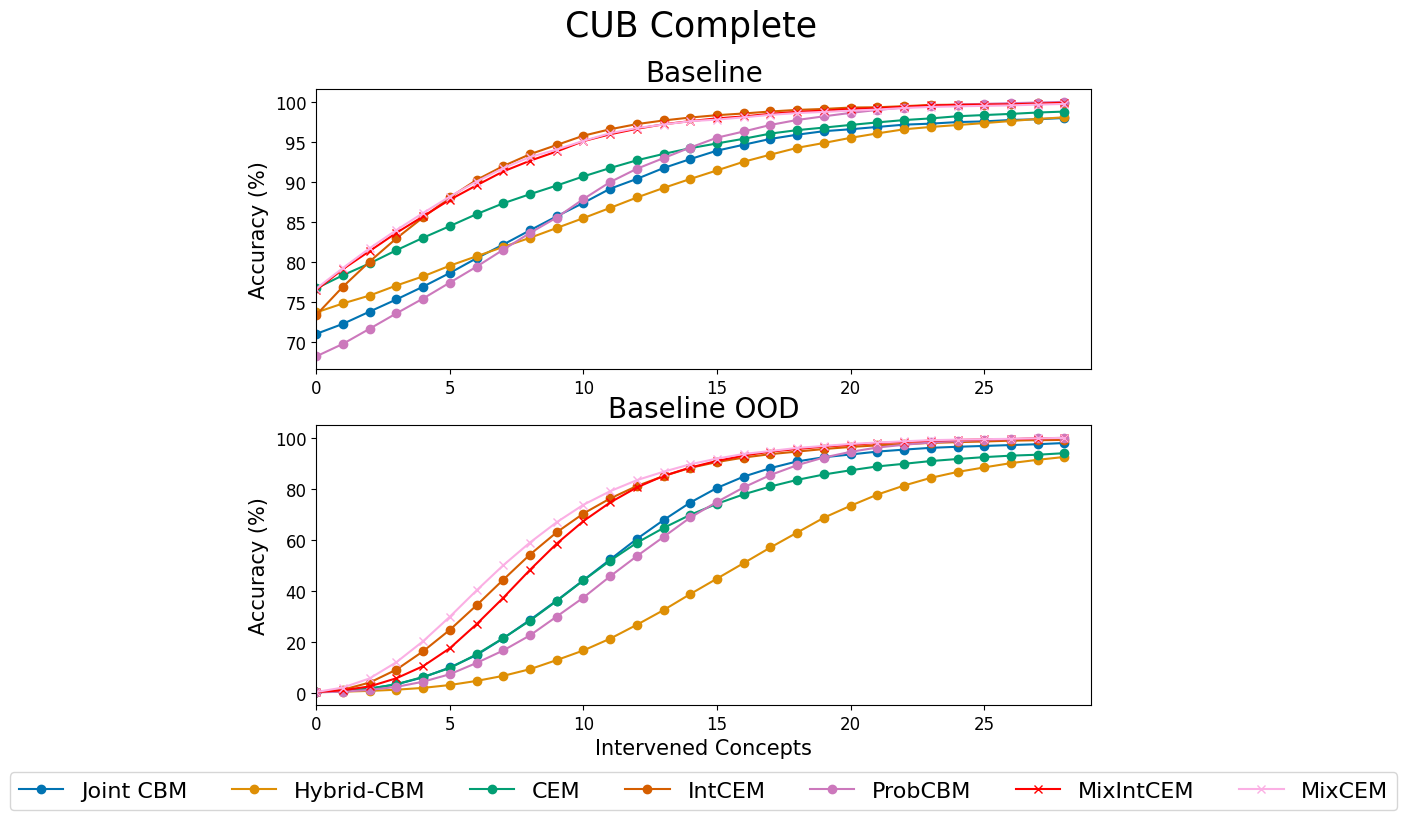

In [8]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 29))
rename_map = {"Linear CMCMixIntCEM": "MixIntCEM", "Linear CMCMixCEM": "MixCEM"}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            "Linear CMCMixIntCEM",
            "Linear CMCMixCEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CUB Complete", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=7,
    )
    plt.savefig(f"../figures/cub_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/cub_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Traveling Birds (Incomplete)

In [9]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Logit CBM (Baseline)': 'CBM_Logit_Baseline_cwl_1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_1',
 'CEM (Baseline)': 'CEM_emb_size_16_Baseline_cwl_1',
 'DNN (Baseline)': 'DNN_extra_dims_200',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1',
 'Linear CMCMixIntCEM No Calibration (Baseline)': 'Linear_CMCMixIntCEM_t_1_r_0.1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1',
 'Linear CMCMixIntCEM (Baseline)': 'Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1',
 'Linear CMCMixCEM No Calibration (Baseline)': 'Linear_CMCMixCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1',
 'Linear CMCMixCEM (Baseline)': 'Linear_CMCMixCEM_t_1_r_1_concat_None_0_mpc_1_t

model_name = Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_1
len(ints) = 3
Baseline Hybrid-CBM means = [24.79001266 24.79576573 24.76124727 24.77275342 24.78425958 24.83603728
 24.83603728 24.84179036]
model_name = CEM_emb_size_16_Baseline_cwl_1
len(ints) = 3
Baseline CEM means = [23.3459901  25.96364055 28.96099413 31.76274307 34.84639282 38.01058566
 41.29559314 44.46553906]
model_name = IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Baseline_cwl_1
len(ints) = 3
Baseline IntCEM means = [22.90300311 28.08077321 33.55770337 39.33954666 45.50684616 51.67414567
 57.57680359 63.04798067]
model_name = ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
len(ints) = 3
Baseline ProbCBM means = [ 5.43090553  6.49522495  7.81267978  9.53860315 11.44287194 13.85341158
 16.5285928  19.04268784]
model_name = Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
len(ints) = 3
Baseline MixIntCEM means = [27.0509722

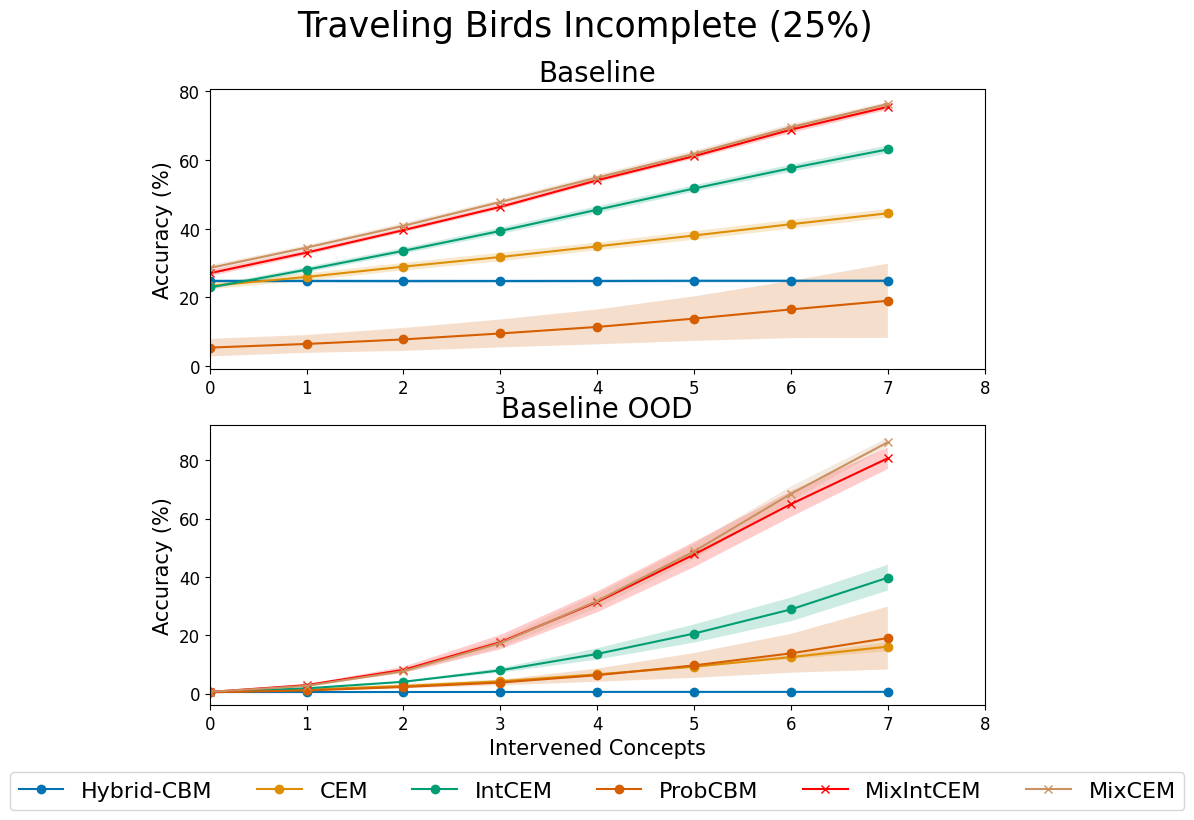

model_name = Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_1
len(ints) = 3
Baseline Hybrid-CBM means = [24.79001266 24.79576573 24.76124727 24.77275342 24.78425958 24.83603728
 24.83603728 24.84179036]
model_name = CEM_emb_size_16_Baseline_cwl_1
len(ints) = 3
Baseline CEM means = [23.3459901  25.96364055 28.96099413 31.76274307 34.84639282 38.01058566
 41.29559314 44.46553906]
model_name = IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Baseline_cwl_1
len(ints) = 3
Baseline IntCEM means = [22.90300311 28.08077321 33.55770337 39.33954666 45.50684616 51.67414567
 57.57680359 63.04798067]
model_name = ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
len(ints) = 3
Baseline ProbCBM means = [ 5.43090553  6.49522495  7.81267978  9.53860315 11.44287194 13.85341158
 16.5285928  19.04268784]
model_name = Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
len(ints) = 3
Baseline MixIntCEM means = [27.0509722

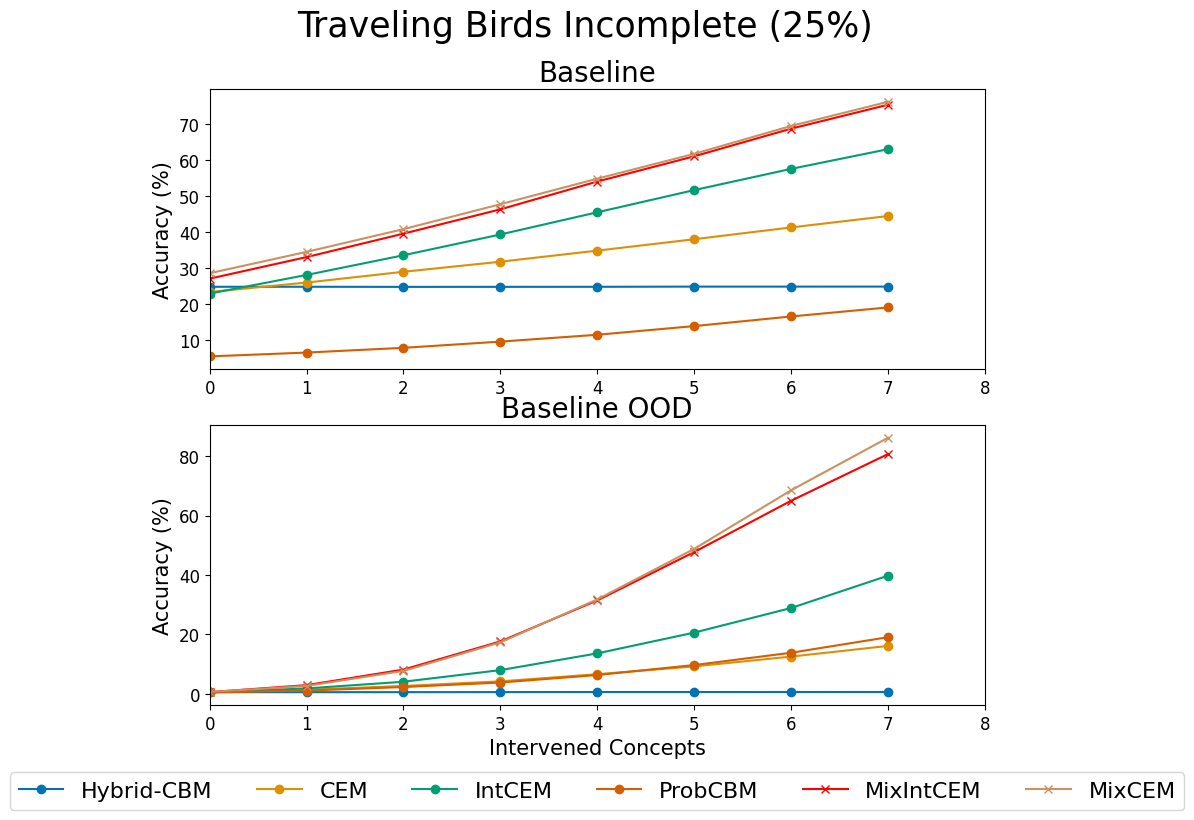

In [14]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 8))
rename_map = {"Linear CMCMixIntCEM": "MixIntCEM", "Linear CMCMixCEM": "MixCEM"}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            # "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "Linear CMCMixIntCEM",
            "Linear CMCMixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            print("model_name =", model_name)
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            print("len(ints) =", len(ints))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Traveling Birds Incomplete (25%)", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=7,
    )
    plt.savefig(f"../figures/traveling_birds_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/traveling_birds_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# CelebA

In [17]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/celeba/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'DNN (Baseline)': 'DNN_extra_dims_200',
 'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_1',
 'Joint Logit CBM (Baseline)': 'CBM_Logit_Baseline_cwl_10',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_10',
 'CEM (Baseline)': 'CEM_emb_size_32_cwl_10',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_5_intervention_task_discount_1.5_emb_size_32_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_cwl_class_hidden_dim_64_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75',
 'Posthoc CBM (Baseline)': 'PCBM_reg_0.1_l1_0.99_penalty_1',
 'Posthoc Hybrid CBM (Baseline)': 'HybridPCBM_reg_0.1_l1_0.99_penalty_1',
 'Linear CMCMixIntCEM No Calibration (Baseline)': 'Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_1_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_5_cwl_1',
 'Linear CMCMixIntCEM (Baseline)': 'Linear_CMCMixIntCEM_t_2_r_1_concat_None_0_mpc_1_tmc_1_emc_1_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_5_cwl_1',
 'Li

Baseline Joint CBM means = [24.18048973 26.02685624 28.38665087 30.65758294 33.2049763  36.27567141
 40.17575039]
Baseline Hybrid-CBM means = [35.42654028 35.59439179 35.79186414 35.89060032 36.01895735 36.19668246
 36.35466035]
Baseline CEM means = [34.89336493 37.69747235 40.58056872 43.66113744 47.34399684 51.01698262
 54.81832543]
Baseline IntCEM means = [36.92733017 40.70892575 45.32977883 50.07898894 56.10189573 62.17417062
 68.83886256]
Baseline ProbCBM means = [31.74368088 35.49565561 39.7906793  44.37203791 49.78278041 55.60821485
 62.96406003]
Baseline MixIntCEM means = [35.02172196 38.85268562 43.37480253 48.60781991 55.37124803 61.73973144
 69.04620853]
Baseline MixCEM means = [31.00315956 35.21919431 39.51421801 43.93759874 49.42733017 55.11453397
 61.43364929]
Baseline OOD Joint CBM means = [10.67338073 11.23617694 12.6678515  16.23222749 22.88704581 30.90442338
 40.17575039]
Baseline OOD Hybrid-CBM means = [10.72274882 10.72274882 10.72274882 10.73262243 10.73262243 10.7

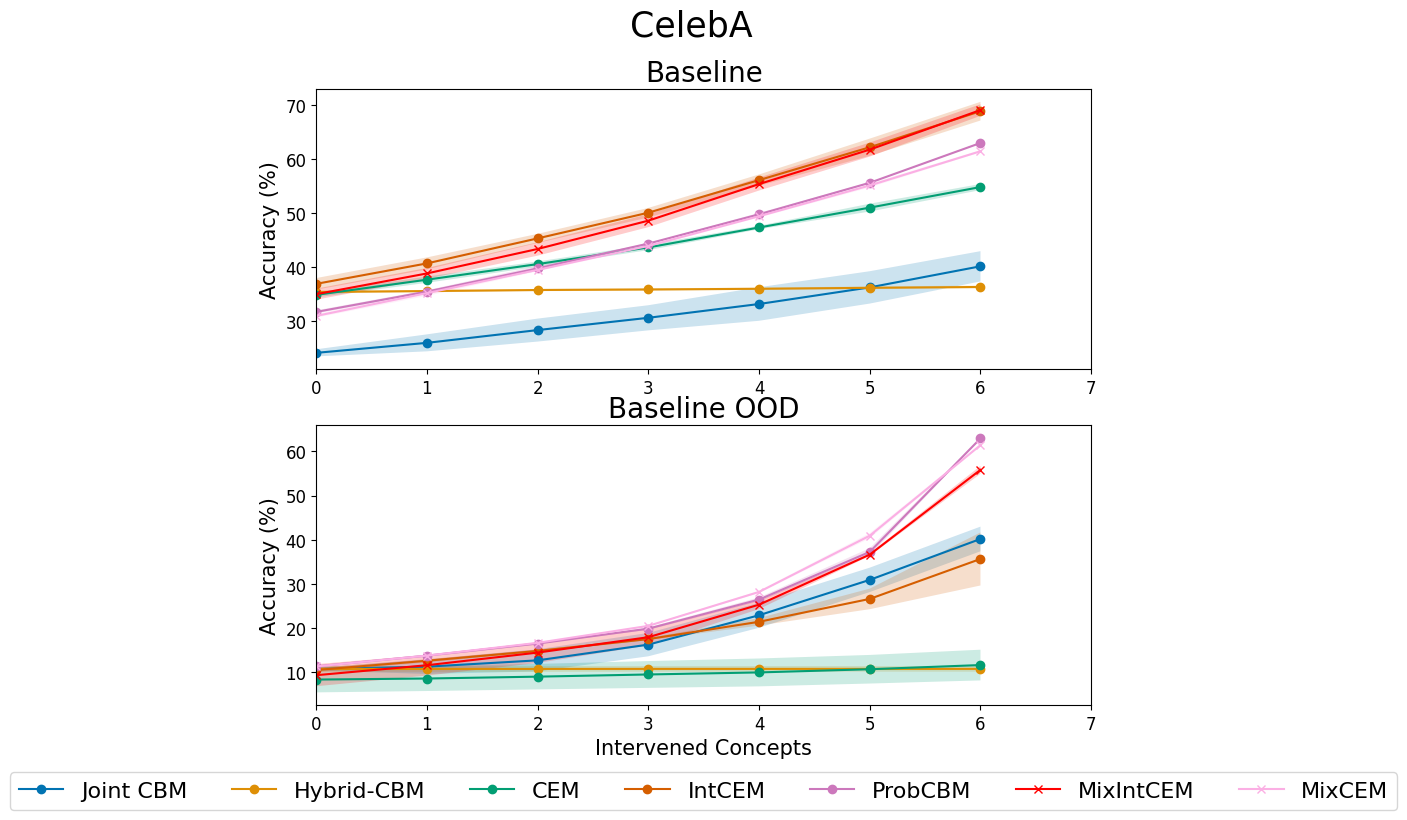

Baseline Joint CBM means = [24.18048973 26.02685624 28.38665087 30.65758294 33.2049763  36.27567141
 40.17575039]
Baseline Hybrid-CBM means = [35.42654028 35.59439179 35.79186414 35.89060032 36.01895735 36.19668246
 36.35466035]
Baseline CEM means = [34.89336493 37.69747235 40.58056872 43.66113744 47.34399684 51.01698262
 54.81832543]
Baseline IntCEM means = [36.92733017 40.70892575 45.32977883 50.07898894 56.10189573 62.17417062
 68.83886256]
Baseline ProbCBM means = [31.74368088 35.49565561 39.7906793  44.37203791 49.78278041 55.60821485
 62.96406003]
Baseline MixIntCEM means = [35.02172196 38.85268562 43.37480253 48.60781991 55.37124803 61.73973144
 69.04620853]
Baseline MixCEM means = [31.00315956 35.21919431 39.51421801 43.93759874 49.42733017 55.11453397
 61.43364929]
Baseline OOD Joint CBM means = [10.67338073 11.23617694 12.6678515  16.23222749 22.88704581 30.90442338
 40.17575039]
Baseline OOD Hybrid-CBM means = [10.72274882 10.72274882 10.72274882 10.73262243 10.73262243 10.7

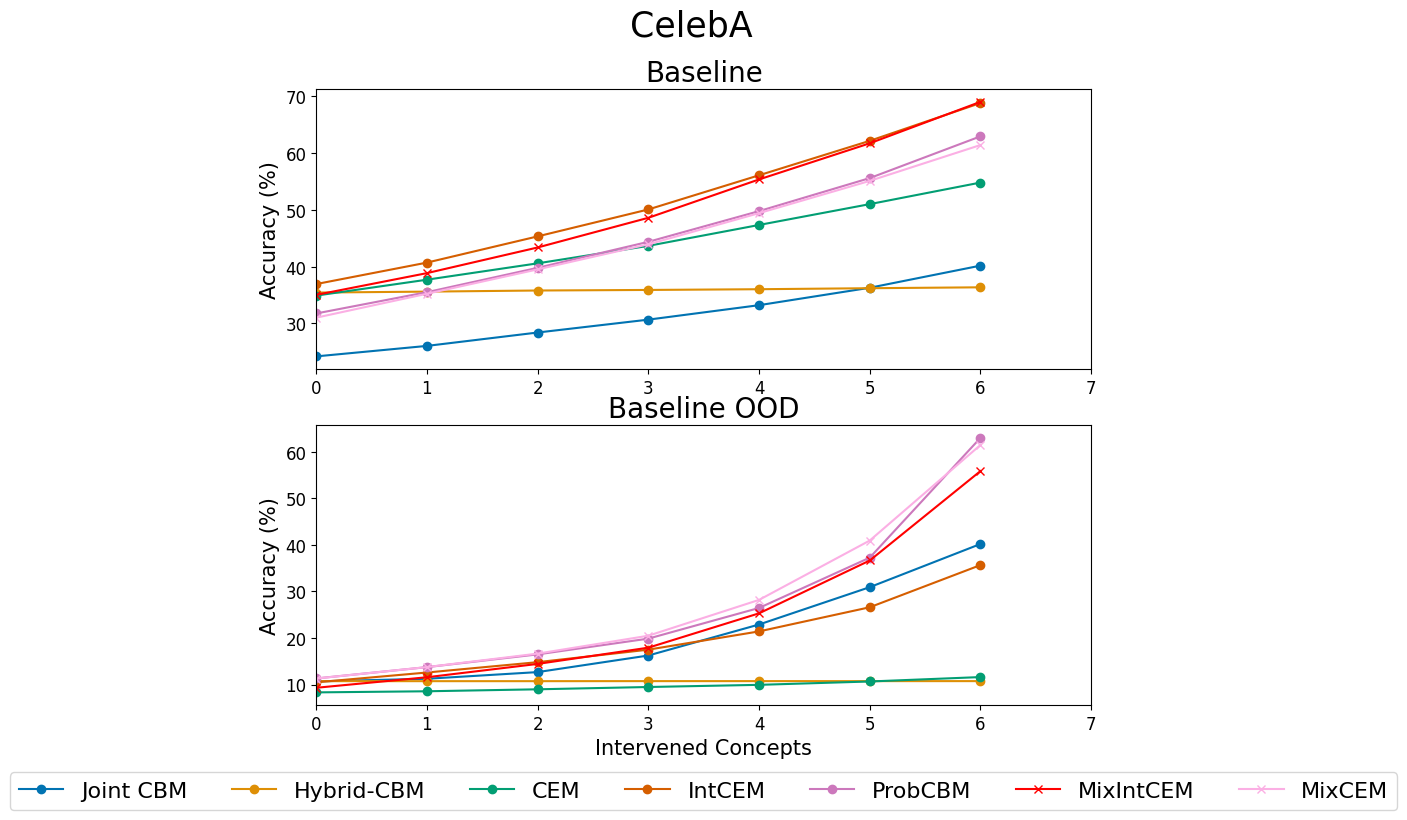

In [18]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 7))
rename_map = {"Linear CMCMixIntCEM": "MixIntCEM", "Linear CMCMixCEM": "MixCEM"}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "Linear CMCMixIntCEM",
            "Linear CMCMixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("CelebA", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=7,
    )
    plt.savefig(f"../figures/celeba{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/celeba{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Waterbirds

In [7]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/waterbirds_complete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_5',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5',
 'CEM (Baseline)': 'CEM_Baseline_cwl_5',
 'DNN (Baseline)': 'DNN_extra_dims_100',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_5_intervention_task_discount_1.5_Baseline_cwl_5',
 'MixCEM (Baseline)': 'MixCEM_n_extra_0_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_32_ml_0_Baseline_cwl_1',
 'ProbCBM (Baseline)': 'ProbCBM_class_hidden_dim_64_hidden_dim_16_cwl_1'}

Baseline Joint CBM means = [82.44735934 82.80405017 83.08019791 83.37360488 83.89713497 83.96041882
 84.15602347 84.55873893 84.76009665 85.16856518 85.41019445 85.83592222
 86.29041537 86.46300771 86.64135312 86.87147624 87.10735243 87.17638937
 87.09584628 87.19940168 87.33747555 87.39500633 87.63088252 87.66540099
 87.73443792 87.67115407 87.55609251 87.57335174 87.72868485]
Baseline Hybrid-CBM means = [83.01116097 83.03417328 83.12046945 83.19525946 83.24703716 83.3160741
 83.50592567 83.51743183 83.53469106 83.62674031 83.6555057  83.76481418
 83.83960419 83.84535727 83.88562881 83.93740651 84.01219653 84.06397423
 84.12150501 84.10999885 84.12150501 84.20780117 84.15027039 84.17903578
 84.24807272 84.38039351 84.39765274 84.50696122 84.63928202]
Baseline CEM means = [80.62938672 80.66965827 80.72718905 80.75595444 80.79622598 80.89402831
 80.96881832 81.00908986 81.08387988 81.04936141 81.16442297 81.10689219
 81.11264527 81.1299045  81.16442297 81.2852376  81.29674376 81.4002991

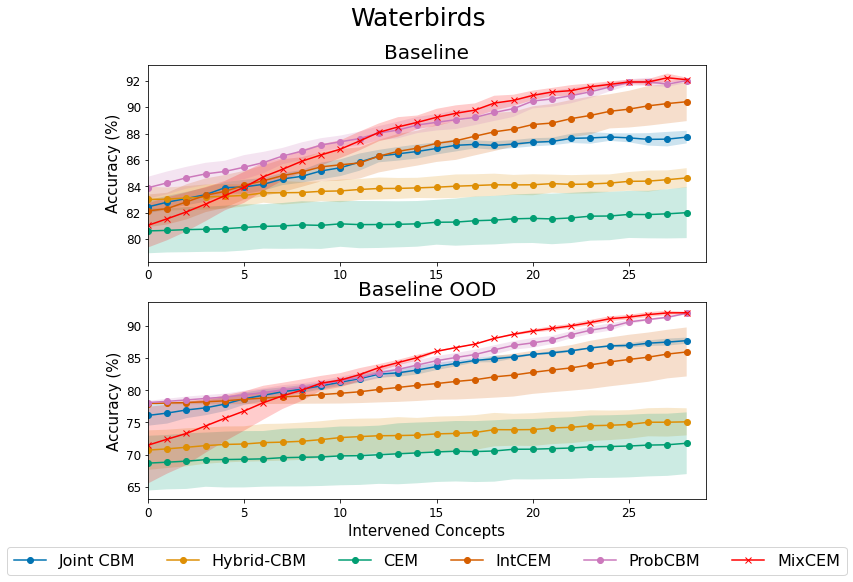

Baseline Joint CBM means = [82.44735934 82.80405017 83.08019791 83.37360488 83.89713497 83.96041882
 84.15602347 84.55873893 84.76009665 85.16856518 85.41019445 85.83592222
 86.29041537 86.46300771 86.64135312 86.87147624 87.10735243 87.17638937
 87.09584628 87.19940168 87.33747555 87.39500633 87.63088252 87.66540099
 87.73443792 87.67115407 87.55609251 87.57335174 87.72868485]
Baseline Hybrid-CBM means = [83.01116097 83.03417328 83.12046945 83.19525946 83.24703716 83.3160741
 83.50592567 83.51743183 83.53469106 83.62674031 83.6555057  83.76481418
 83.83960419 83.84535727 83.88562881 83.93740651 84.01219653 84.06397423
 84.12150501 84.10999885 84.12150501 84.20780117 84.15027039 84.17903578
 84.24807272 84.38039351 84.39765274 84.50696122 84.63928202]
Baseline CEM means = [80.62938672 80.66965827 80.72718905 80.75595444 80.79622598 80.89402831
 80.96881832 81.00908986 81.08387988 81.04936141 81.16442297 81.10689219
 81.11264527 81.1299045  81.16442297 81.2852376  81.29674376 81.4002991

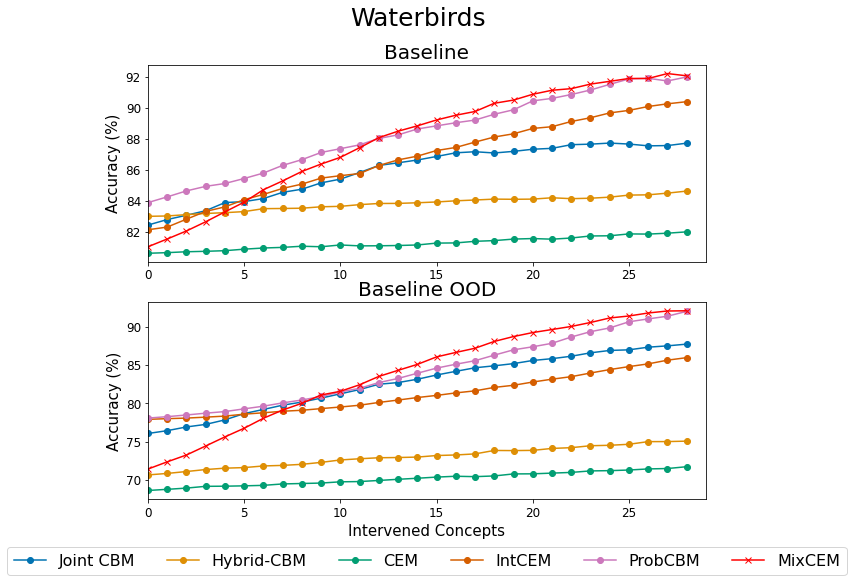

In [8]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 29))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Waterbirds", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/waterbirds_attributes{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/waterbirds_attributes{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

In [21]:
results_dir = '/anfs/bigdisc/me466/mixcem_results/waterbirds_species/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Baseline_cwl_0.1',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_Sigmoid_extra_dims_100_Baseline_cwl_0.1',
 'CEM (Baseline)': 'CEM_Baseline_emb_size_8_cwl_1',
 'DNN (Baseline)': 'DNN_extra_dims_100',
 'IntCEM (Baseline)': 'IntCEM_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_0.1',
 'MixCEM (Baseline)': 'MixCEM_n_extra_0_entr_0_dis_1.01_ip_[0.25, 0.5, 0.75, 1]_dip_0.1_cl_0_mix_True_shared_True_emb_size_32_ml_0_Baseline_cwl_0.1',
 'ProbCBM (Baseline)': 'ProbCBM_class_hidden_dim_8_hidden_dim_8_cwl_1'}

Baseline Joint CBM means = [89.11632302 89.27521768 89.15710788 89.43913312 89.73895561 90.24332111
 91.95523928 95.12071459 99.89894461]
Baseline Hybrid-CBM means = [86.97916669 86.97746259 86.97649956 86.97401428 86.97535157 86.97847985
 86.97522702 86.97733076 86.96950411]
Baseline CEM means = [87.48032941 87.4807553  87.4845666  87.48831976 87.48681815 87.48917855
 87.48677727 87.49370718 87.49271513]
Baseline IntCEM means = [83.31541657 83.41482109 83.45612426 83.54197594 83.6426449  83.71142692
 83.79287348 83.87927076 83.951808  ]
Baseline ProbCBM means = [50. 50. 50. 50. 50. 50. 50. 50. 50.]
Baseline MixCEM means = [ 83.34949464  86.43366885  88.68613523  91.4567025   94.0737165
  96.28450986  98.34292067  99.63301318 100.        ]
Baseline OOD Joint CBM means = [63.68146412 65.29703065 67.48114363 70.26528278 73.45430971 77.17143177
 82.78226758 90.78886127 99.89894461]
Baseline OOD Hybrid-CBM means = [61.47420813 61.47470889 61.4781186  61.47500994 61.48865466 61.48978842
 61

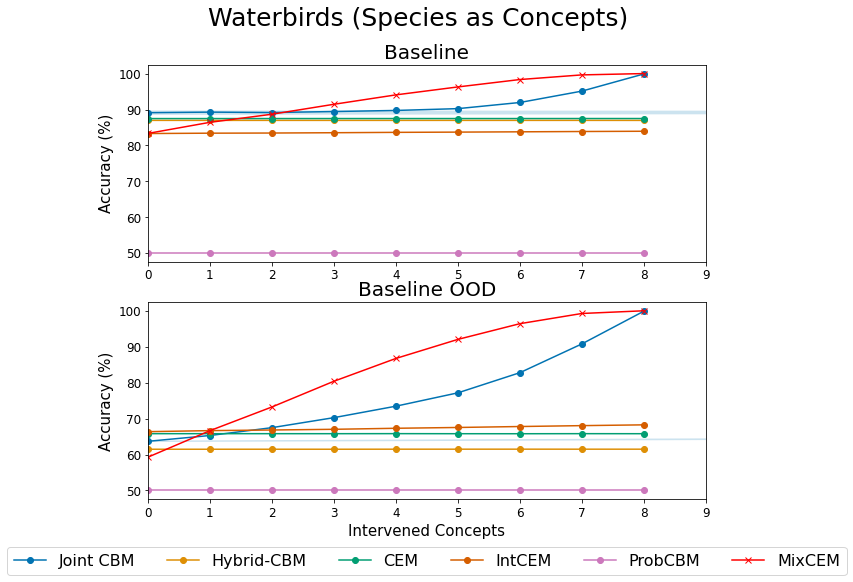

Baseline Joint CBM means = [89.11632302 89.27521768 89.15710788 89.43913312 89.73895561 90.24332111
 91.95523928 95.12071459 99.89894461]
Baseline Hybrid-CBM means = [86.97916669 86.97746259 86.97649956 86.97401428 86.97535157 86.97847985
 86.97522702 86.97733076 86.96950411]
Baseline CEM means = [87.48032941 87.4807553  87.4845666  87.48831976 87.48681815 87.48917855
 87.48677727 87.49370718 87.49271513]
Baseline IntCEM means = [83.31541657 83.41482109 83.45612426 83.54197594 83.6426449  83.71142692
 83.79287348 83.87927076 83.951808  ]
Baseline ProbCBM means = [50. 50. 50. 50. 50. 50. 50. 50. 50.]
Baseline MixCEM means = [ 83.34949464  86.43366885  88.68613523  91.4567025   94.0737165
  96.28450986  98.34292067  99.63301318 100.        ]
Baseline OOD Joint CBM means = [63.68146412 65.29703065 67.48114363 70.26528278 73.45430971 77.17143177
 82.78226758 90.78886127 99.89894461]
Baseline OOD Hybrid-CBM means = [61.47420813 61.47470889 61.4781186  61.47500994 61.48865466 61.48978842
 61

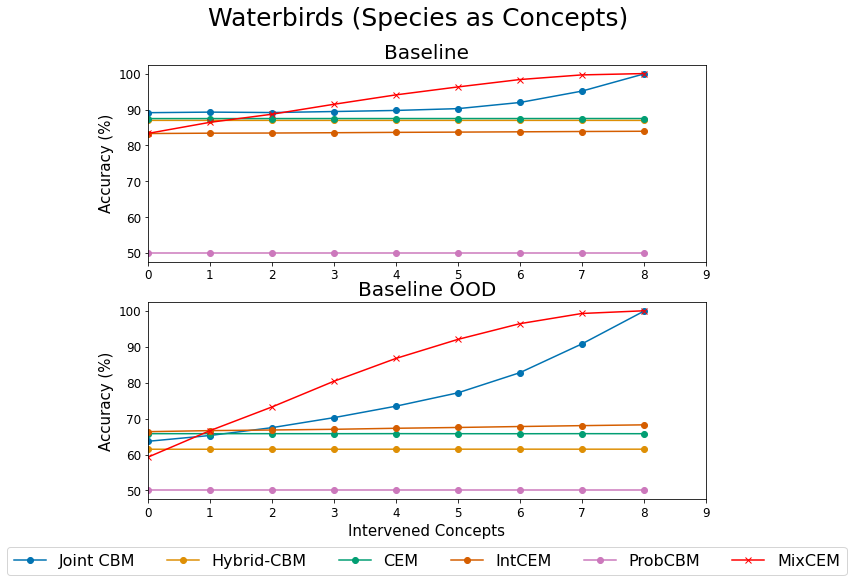

In [22]:
clrs = sns.color_palette("colorblind", 20)
xticks = list(range(0, 201, 25))
rename_map = {}
for show_variance in [True, False]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), squeeze=False)
    for mode_name, mode_key, (row, col) in [
            ("Baseline", " (Baseline)", (0, 0)),
            ("Baseline OOD", " (Baseline)", (1, 0)),
    ]:
        ax = axs[row, col]
        for idx, label in enumerate([
            "Joint CBM",
            "Hybrid-CBM",
            "CEM",
            # "Sigmoidal CEM",
            "IntCEM",
            "ProbCBM",
            # "Mixing-CEM",
            "MixCEM",
            # "new_Mixing-CEM",
        ]):
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "MixCEM" in label else "-o",
                color=color,
                label=label,
            )
            print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        # ax.set_xticks(xticks)
        if col == 0:
            ax.set_ylabel("Accuracy (%)", fontsize=15)
        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(mode_name, fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Waterbirds (Species as Concepts)", fontsize=25)
    ax.legend(
        handles,
        labels,
        fontsize=16,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.2),
        ncol=6,
    )
    plt.savefig(f"figures/waterbirds_species{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/waterbirds_species{'_variance' if show_variance else ''}.png", bbox_inches='tight')
    plt.show()

# Abstract Figures

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixCEM No Calibration (Baseline): Linear_CMCMixCE

/tmp/ipykernel_14279/115353232.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/115353232.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/115353232.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-x" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/115353232.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/115353232.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the 

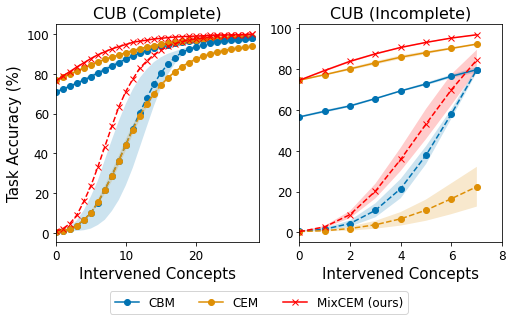

In [12]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "Entropy CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Joint CBM": "CBM",
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
}
show_variance = True


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
    name='CUB (Complete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        if "Mix" in label:
            color = 'red'
        else:
            color = clrs[idx]
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        ax.plot(
            means,
            "-x" if "Mix" in label else "-o",
            color=color,
            label=label,
            linestyle=linestyle,
            
        )
        # print(mode_name, label, "means =", means)
        xticks = list(range(0, len(means)))
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, len(means))
    ax.set_ylabel("Task Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(results_to_use['name'], fontsize=16)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

ax = axs[1]


results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        if "Mix" in label:
            color = 'red'
        else:
            color = clrs[idx]
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        ax.plot(
            means,
            "-x" if "Mix" in label else "-o",
            color=color,
            label=label,
            linestyle=linestyle,
            
        )
        # print(mode_name, label, "means =", means)
        xticks = list(range(0, len(means)))
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, len(means))
    ax.set_ylabel("", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(results_to_use['name'], fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(-0.2,-0.2),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions_complete_{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions_complete_{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

/tmp/ipykernel_14279/4114515822.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/4114515822.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/4114515822.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-x" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/4114515822.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_14279/4114515822.py:71: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and

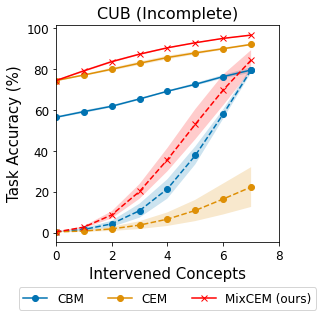

In [13]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "Entropy CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Joint CBM": "CBM",
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
}
show_variance = True


fig, ax = plt.subplots(figsize=(4, 4))

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        if "Mix" in label:
            color = 'red'
        else:
            color = clrs[idx]
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        ax.plot(
            means,
            "-x" if "Mix" in label else "-o",
            color=color,
            label=label,
            linestyle=linestyle,
            
        )
        # print(mode_name, label, "means =", means)
        xticks = list(range(0, len(means)))
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, len(means))
    ax.set_ylabel("Task Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(results_to_use['name'], fontsize=16)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.18),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

/tmp/ipykernel_1480997/409318125.py:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


AttributeError: 'Line2D' object has no property 'size'

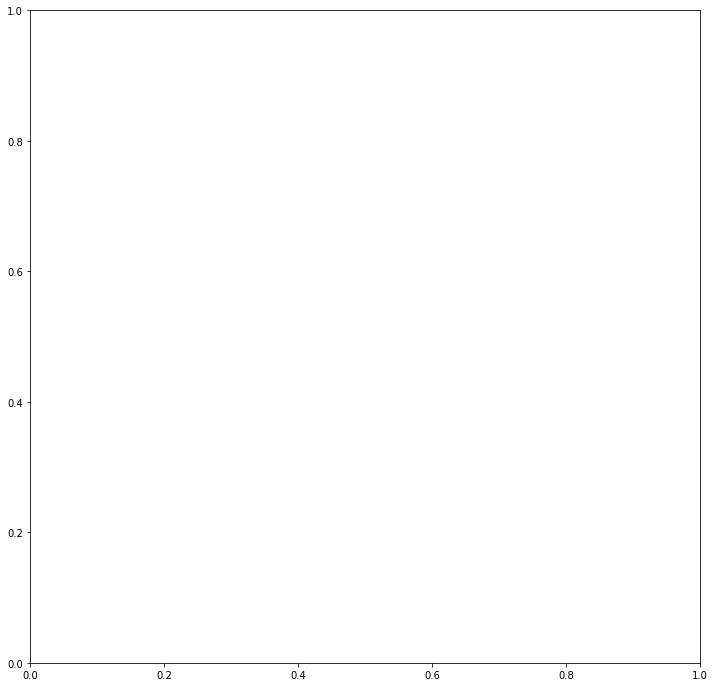

In [15]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "CEM",
    "ProbCBM",
    # "Entropy CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Joint CBM": "CBM",
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
}
show_variance = True


fig, ax = plt.subplots(figsize=(12, 12))

results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)

results = results_to_use['results']
used_select_metric = results_to_use.get(
    'select_metric',
    select_metric,
)
results_to_use['selected_models'] = joblib.load(os.path.join(results_to_use['path'], f'selected_models_{used_select_metric}.joblib'))
print("For dataset", results_to_use['name'], "we selected")
for key, val in results_to_use['selected_models'].items():
    print(f"\t{key}: {val}")
selected_models = results_to_use['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(baselines_to_include):
        label = results_to_use.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", results_to_use['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        if "Mix" in label:
            color = 'red'
        else:
            color = clrs[idx]
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        ax.plot(
            means,
            "-x" if "Mix" in label else "-o",
            color=color,
            label=label,
            linestyle=linestyle,
            size=50,
        )
        # print(mode_name, label, "means =", means)
        xticks = list(range(0, len(means)))
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, len(means))
    ax.set_ylabel("Task Accuracy (%)", fontsize=10+15)
    ax.set_xlabel("Intervened Concepts", fontsize=10+15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(results_to_use['name'], fontsize=10+16)
    handles, labels = ax.get_legend_handles_labels()



results_to_use = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
    name='CUB (Incomplete)',
    rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
)
results_to_use['results'] = joblib.load(
    os.path.join(results_to_use['path'], 'results.joblib')
)
ax.legend(
    handles[:len(baselines_to_include)],
    labels[:len(baselines_to_include)],
    fontsize=10+12,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.1),
    ncol=len(baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions_probcbm{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions_probcbm{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Latex Tables

In [24]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB (Incomplete)',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2 (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2 (Incomplete)',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]
rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
metric = 'test_acc_y'
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
best_col_results = defaultdict(lambda: (-float("inf"), None))
col_results =  defaultdict(list)
for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_val = np.array(get_metric_from_dict(
            results,
            model_name,
            metric,
        ))
        used_name = rename_map.get(label, label)
        if len(new_row) == 0:
            new_row.append(used_name)
        mean = np.mean(metric_val, axis=0) * 100
        std = np.std(metric_val, axis=0) * 100
        if mean > best_col_results[col][0]:
            best_col_results[col] = (mean, std)
        col_results[col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        mean, std = col_results[col][idx]
        if mean + std >= (best_col_results[col][0] - best_col_results[col][1]):
            new_row.append("\\textbf{" + f"{mean:.2f} ± {std:.2f}" + "}")
        else:
            new_row.append(f"{mean:.2f} ± {std:.2f}")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results (reported as percentages) across datasets. Mean "
            "± standard deviation values are reported for each method. The highest "
            "result for each dataset and those within a standard deviation of "
            "this result are highlighted in bold."
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


-- Example 1: Basic --
Texttable Output:
+-------------+------------+------------+------------+------------+------------+
|   Method    |    CUB     | CUB (Incom |   CelebA   |    AwA2    | AwA2 (Inco |
|             | (Complete) |   plete)   |            | (Complete) |  mplete)   |
+=============+============+============+============+============+============+
|     DNN     |  71.18 ±   |  71.42 ±   |  25.39 ±   |  89.20 ±   |  89.33 ±   |
|             |    0.67    |    0.30    |    0.49    |    0.26    |    0.22    |
+-------------+------------+------------+------------+------------+------------+
|  Joint CBM  |  70.97 ±   |  56.46 ±   |  24.18 ±   |  87.52 ±   |  76.28 ±   |
|             |    0.76    |    0.48    |    0.65    |    0.41    |    0.82    |
+-------------+------------+------------+------------+------------+------------+
| Hybrid-CBM  |  73.65 ±   |  72.13 ±   |  35.43 ±   |  88.18 ±   |  89.39 ±   |
|             |    0.23    |    0.57    |    0.23    |    0.65    | 

In [26]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB (Incomplete)',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2 (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2 (Incomplete)',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "Entropy CMCMixCEM",
    "Entropy CMCMixIntCEM",
]
rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
metric = 'test_auc_c'
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
best_col_results = defaultdict(lambda: (-float("inf"), None))
col_results =  defaultdict(list)
for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_val = np.array(get_metric_from_dict(
            results,
            model_name,
            metric,
        ))
        used_name = rename_map.get(label, label)
        if len(new_row) == 0:
            new_row.append(used_name)
        mean = np.mean(metric_val, axis=0) * 100
        std = np.std(metric_val, axis=0) * 100
        if mean > best_col_results[col][0]:
            best_col_results[col] = (mean, std)
        col_results[col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        mean, std = col_results[col][idx]
        if mean + std >= (best_col_results[col][0] - best_col_results[col][1]):
            new_row.append("\\textbf{" + f"{mean:.2f} ± {std:.2f}" + "}")
        else:
            new_row.append(f"{mean:.2f} ± {std:.2f}")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Mean Concept AUC results (percentages) across datasets. Mean ± "
            "standard deviation values are reported for each method. The "
            "highest result for each dataset and those within a standard "
            "deviation of this result are highlighted in bold."
        ),
        caption_above=True,
        label="tab:concept_auc_summary",
        position="ht",
        use_booktabs=True,
))


-- Example 1: Basic --
Texttable Output:
+-------------+------------+------------+------------+------------+------------+
|   Method    |    CUB     | CUB (Incom |   CelebA   |    AwA2    | AwA2 (Inco |
|             | (Complete) |   plete)   |            | (Complete) |  mplete)   |
+=============+============+============+============+============+============+
|             |  89.80 ±   |  88.15 ±   |  80.12 ±   | \textbf{94 |  93.25 ±   |
|  Joint CBM  |    0.14    |    0.14    |    0.21    |   .42 ±    |    0.30    |
|             |            |            |            |   0.16}    |            |
+-------------+------------+------------+------------+------------+------------+
|             | \textbf{94 | \textbf{88 |  87.66 ±   | \textbf{94 |  95.81 ±   |
| Hybrid-CBM  |   .53 ±    |   .97 ±    |    0.18    |   .42 ±    |    0.01    |
|             |   0.04}    |   0.20}    |            |   0.19}    |            |
+-------------+------------+------------+------------+------------+-

# Combined Results

In [ ]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB (Incomplete)',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2 (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2 (Incomplete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name='Travelbirds (Complete)',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name='Travelbirds (Incomplete)',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Line

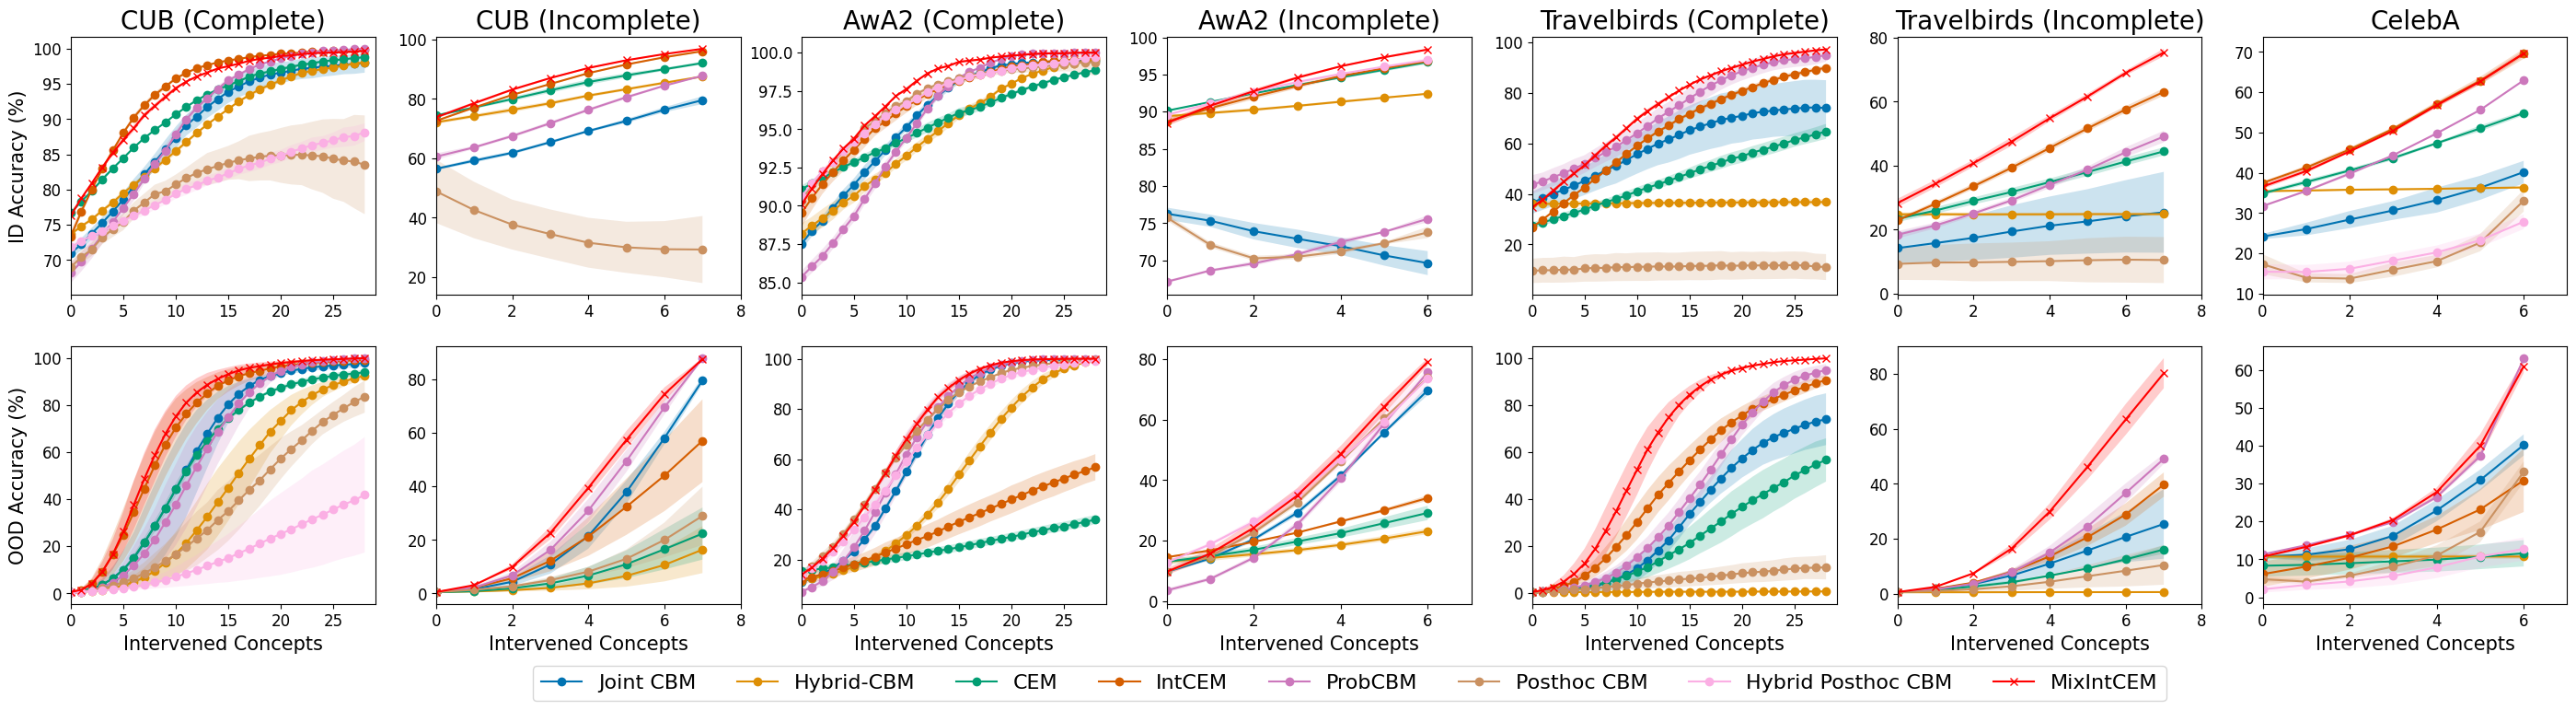

In [15]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-3,-0.2),
    ncol=8,
)
plt.savefig(f"../figures/all_results_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_results_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Line

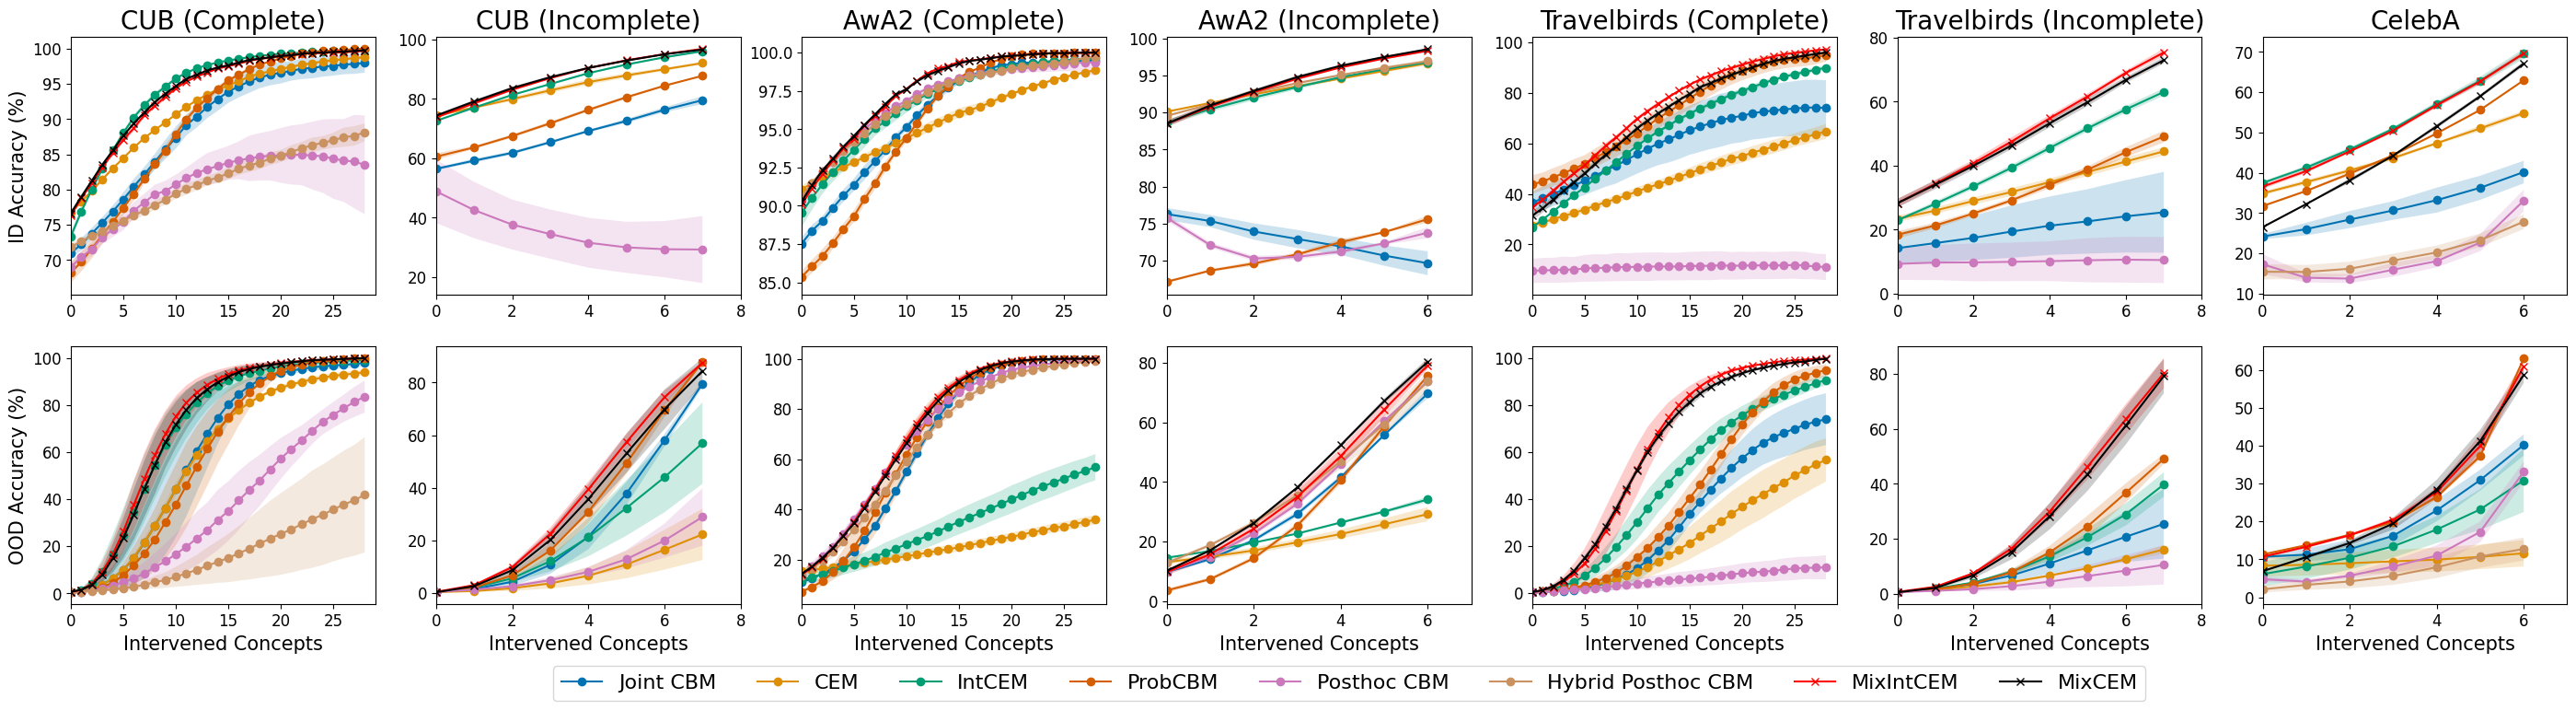

In [16]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    "Entropy CMCMixCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            elif label == "MixCEM":
                color = 'black'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-3,-0.2),
    ncol=8,
)
plt.savefig(f"../figures/main_results_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/main_results_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

#### All Non-OOD Results

In [8]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB (Incomplete)',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2 (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2 (Incomplete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Line

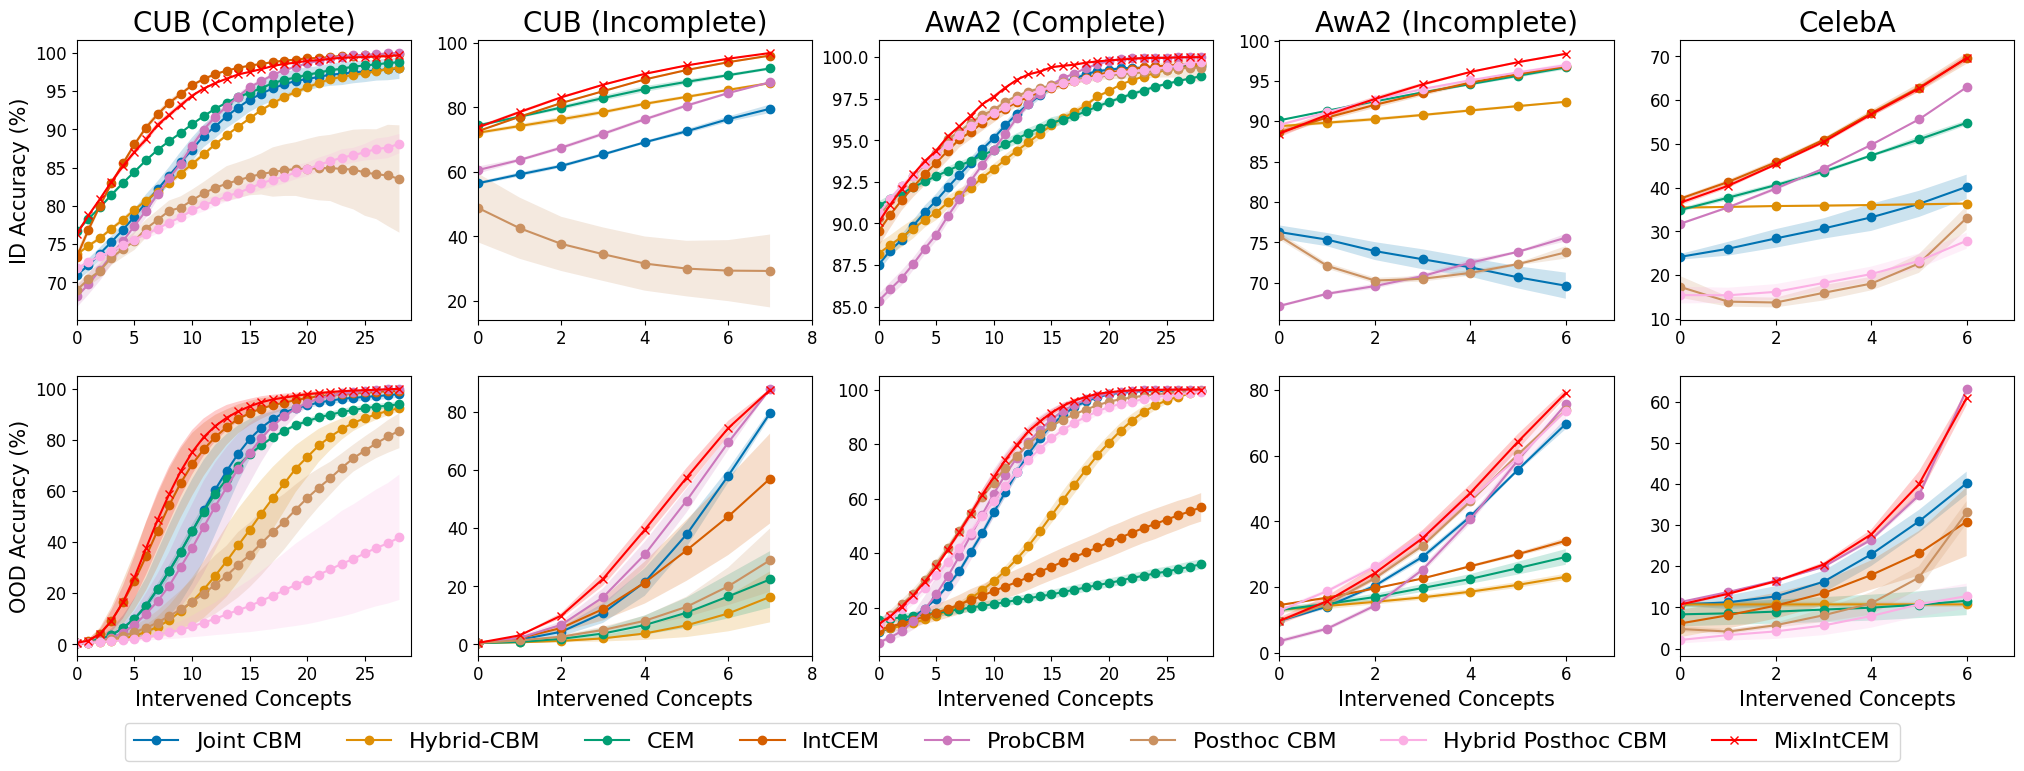

In [9]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=8,
)
plt.savefig(f"../figures/all_non_ood_results_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

For dataset CUB (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_10
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_10
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_1e-06_l1_0.99_penalty_1
	Posthoc Hybrid CBM (Baseline): HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	Linear CMCMixIntCEM No Calibration (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Linear CMCMixIntCEM (Baseline): Linear_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Line

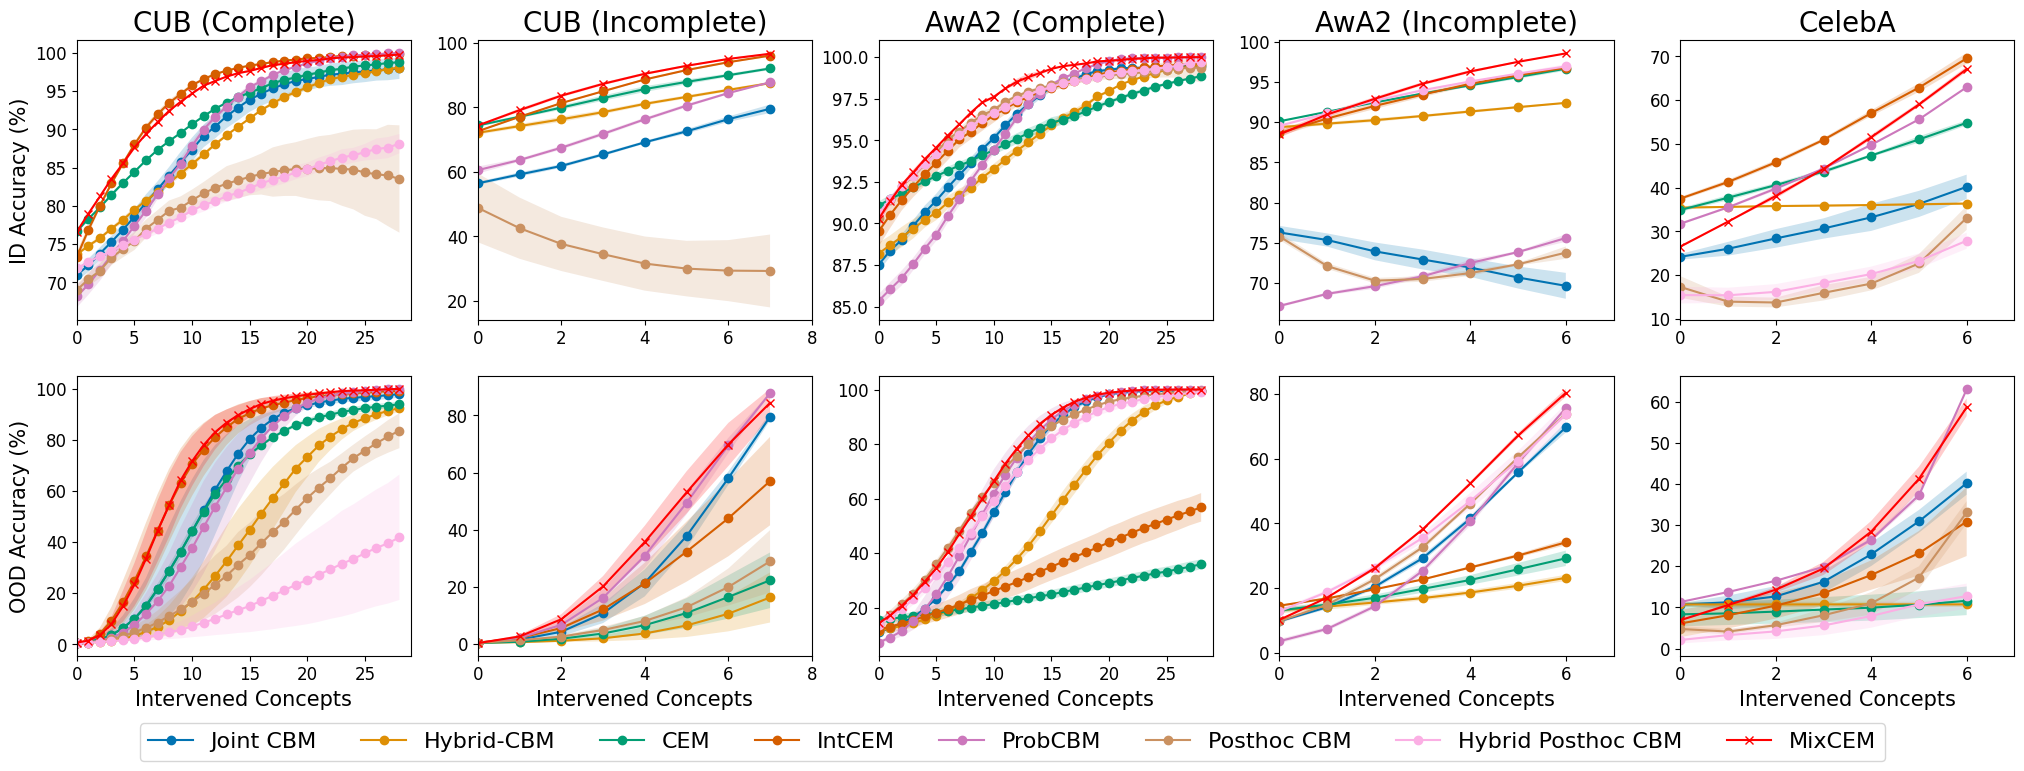

In [10]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=8,
)
plt.savefig(f"../figures/all_non_ood_results_mixcem_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_mixcem_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

#### OOD Results

In [11]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name='Travelbirds (Complete)',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),

    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name='Travelbirds (Incomplete)',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset Travelbirds (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_

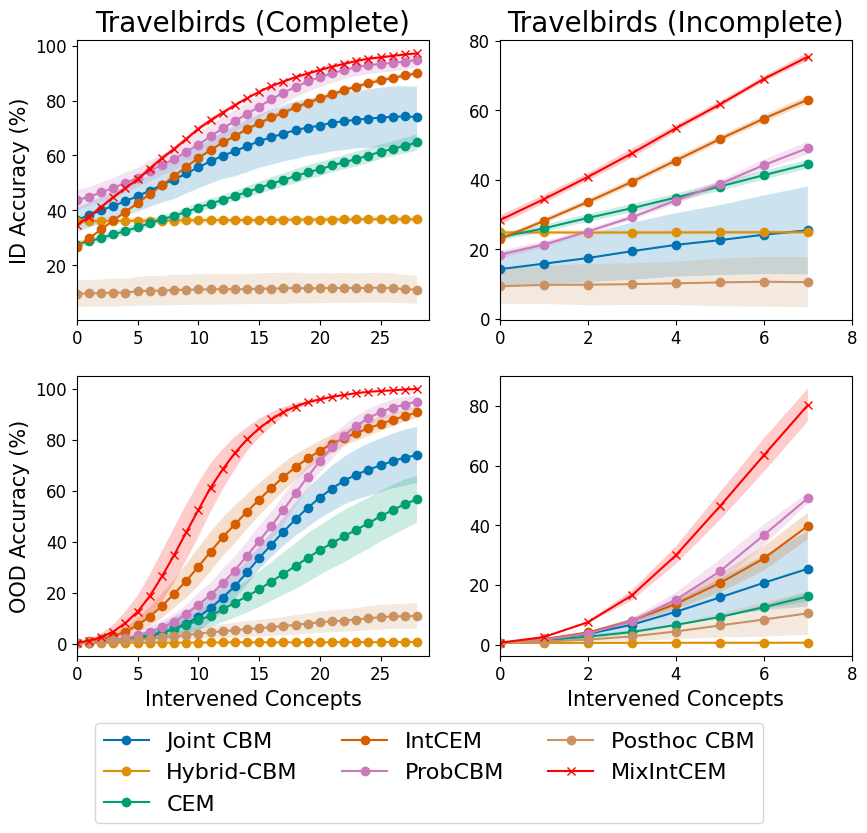

In [12]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.2,-0.2),
    ncol=3,
)
plt.savefig(f"../figures/all_ood_results_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_ood_results_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

-------

In [18]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB (Complete)',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name='Travelbirds (Complete)',
        # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2 (Complete)',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset Travelbirds (Complete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Joint Logit CBM (Baseline): CBM_Logit_Baseline_cwl_5
	Sequential CBM (Baseline): CBM_Seq
	Independent CBM (Baseline): CBM_Ind
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_200_Baseline_cwl_5
	CEM (Baseline): CEM_emb_size_16_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_class_hidden_dim_32_hidden_dim_4_cwl_1
	Posthoc CBM (Baseline): PCBM_reg_0.1_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1.1_

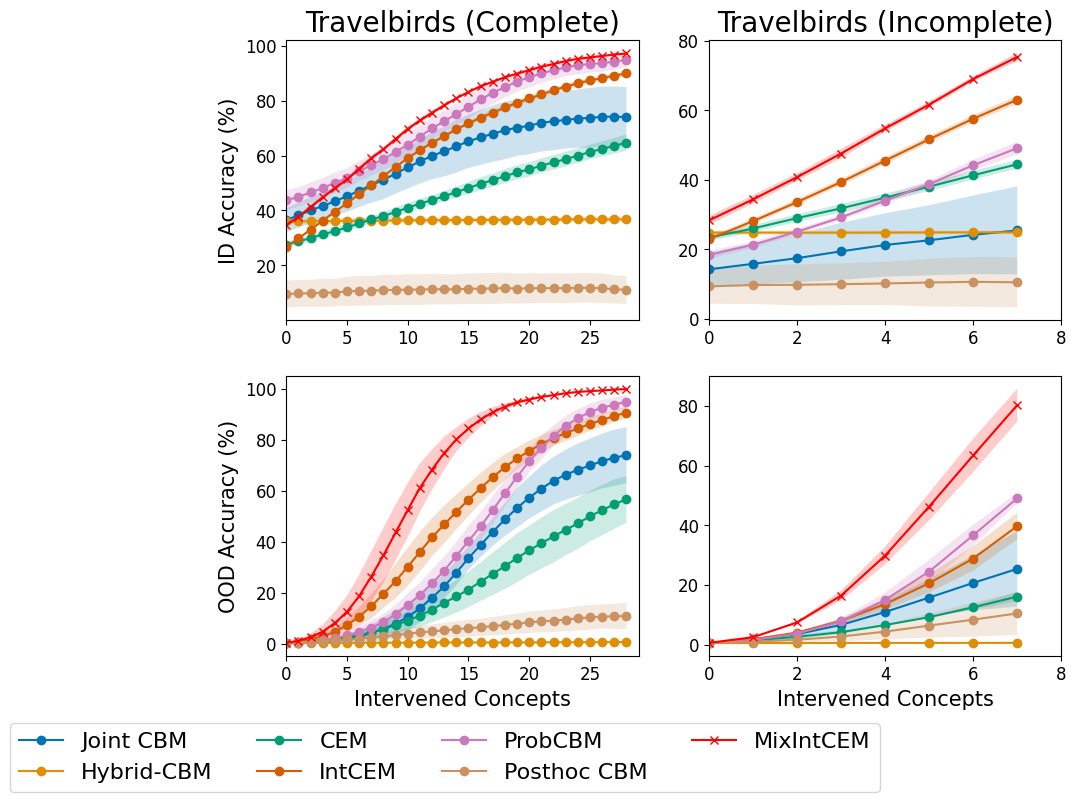

In [13]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.75,-0.2),
    ncol=4,
)
plt.savefig(f"../figures/all_results_together_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_results_together_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

In [ ]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.75,-0.2),
    ncol=4,
)
plt.savefig(f"../figures/all_results_together_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_results_together_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

In [16]:
results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB (Incomplete)',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2 (Incomplete)',
    ),
    dict(
            path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
            name='Travelbirds (Incomplete)',
            # remap={'Entropy CMCMixIntCEM': 'Linear CMCMixIntCEM'}
        ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
    ),
]
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

For dataset CUB (Incomplete) we selected
	DNN (Baseline): DNN_extra_dims_200
	Joint CBM (Baseline): CBM_Sigmoid_Baseline_cwl_1
	Hybrid-CBM (Baseline): Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	CEM (Baseline): CEM_Baseline_cwl_1
	IntCEM (Baseline): IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	ProbCBM (Baseline): ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	Posthoc CBM (Baseline): PCBM_reg_0.001_l1_0.99_penalty_1
	Hybrid Posthoc CBM (Baseline): HybridPCBM_reg_0.1_l1_0.99_penalty_1
	Entropy CMCMixIntCEM No Calibration (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixIntCEM (Baseline): Entropy_CMCMixIntCEM_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1.1_iw_0.1_cwl_1
	Entropy CMCMixCEM No Calibration (Baseline): Entropy_CMCM

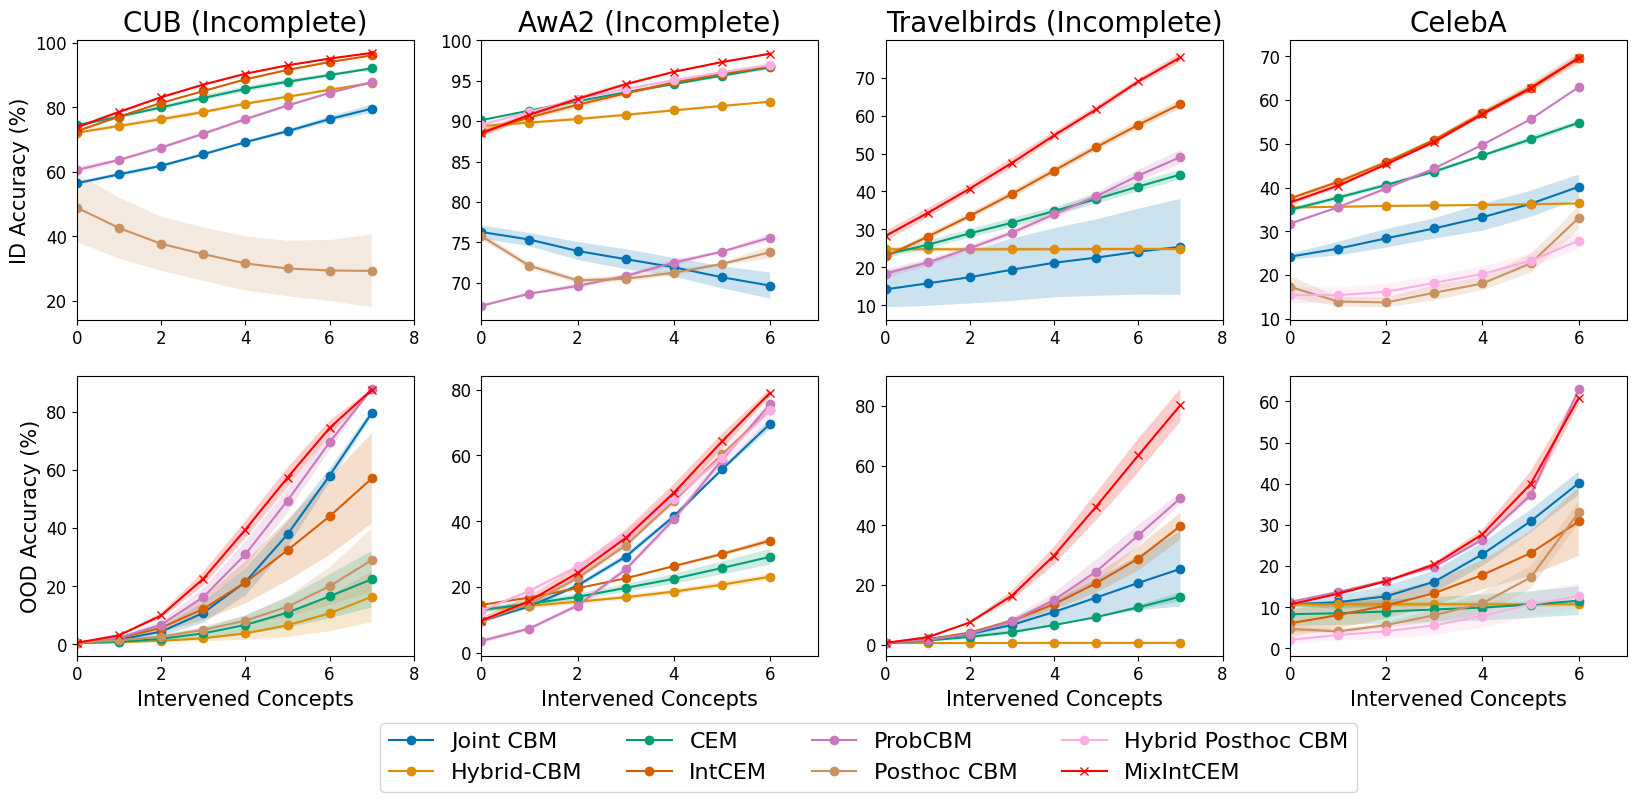

In [17]:
clrs = sns.color_palette("colorblind", 20)
baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    # "Mixing-CEM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixIntCEM",
    # "Linear CMCMixIntCEM",
    # "Entropy CMCMixCEM",
    # "Linear CMCMixCEM",
]

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
# select_metric = 'val_acc_y'

rename_map = {
    "Linear CMCMixIntCEM": "MixIntCEM",
    "Linear CMCMixCEM": "MixCEM",
    "Entropy CMCMixIntCEM": "MixIntCEM",
    "Entropy CMCMixCEM": "MixCEM",
    "Posthoc Hybrid CBM": "Hybrid Posthoc CBM",
}
show_variance = True


fig, axs = plt.subplots(2, len(results_to_include), figsize=(5*len(results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    print("For dataset", dataset_results['name'], "we selected")
    for key, val in dataset_results['selected_models'].items():
        print(f"\t{key}: {val}")
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(baselines_to_include):
            label = dataset_results.get('remap', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{'OOD_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            if label == "MixIntCEM":
                color = 'red'
            else:
                color = clrs[idx]
            ax.plot(
                means,
                "-x" if "Mix" in label else "-o",
                color=color,
                label=label,
            )
            # print(mode_name, label, "means =", means)
            xticks = list(range(0, len(means)))
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, len(means))
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (%)", fontsize=15)
            else:
                ax.set_ylabel("OOD Accuracy (%)", fontsize=15)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts", fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=20)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=4,
)
plt.savefig(f"../figures/all_results_together_incomplete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_results_together_incomplete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Sandbox

In [39]:
CONCEPT_SEMANTICS_SENTENCE_TEST = [
    "a bird with a dagger bill",
    "a bird with am all-purpose bill",
    "a bird with brown wings",
    "a bird with dark black wings",
    "a bird with white wings",
    "a brown bird",
    "a dark black bird",
    "a white bird",
]

IDXs = [
    1,
    6,
    10,
    20,
    21,
    249,
    259,
    260,
]


CONCEPT_SEMANTICS_NEGATION_TEST = [
    "a bird with a bill",
    "a bird with a bill",
    "bird wings",
    "bird wings",
    "bird wings",
    "a bird",
    "a bird",
    "a bird",
]

In [1]:
import os
import numpy as np
import pandas as pd

def attr_line_to_val(line):
    return int(line.split(" ")[2])

def get_sample_attributes(idx, lines):
    return np.array([
        attr_line_to_val(lines[x]) for x in range((idx - 1) * 312, idx * 312)
    ])
    
root_dir = "/anfs/bigdisc/me466/waterbirds"
cub_root_dir = "/homes/me466/data/CUB200/"
metadata_df = pd.read_csv(
    os.path.join(root_dir, 'metadata.csv')
)
image_true_idx = metadata_df['img_id'].values
with open(
    os.path.join(
        cub_root_dir,
        'CUB_200_2011/attributes/image_attribute_labels.txt',
    ),
    'r',
) as f:
    lines = [x.rstrip() for x in f]
attributes = np.array([
    get_sample_attributes(idx, lines) for idx in image_true_idx
])

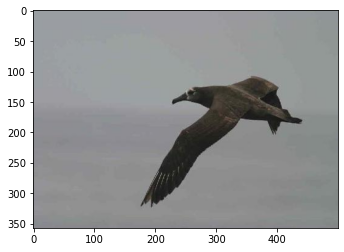

test_img_idx = 24
Processing 'blue wings' and 'wings without any blue' with similarities tensor([[0.8990]]) (between them), tensor([[0.2409]]) (pos emb), tensor([[0.2383]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.4474)
cosine similarity probs of correct label 0 = 0.43520424
Processing 'brown wings' and 'wings without any brown' with similarities tensor([[0.9139]]) (between them), tensor([[0.2669]]) (pos emb), tensor([[0.2432]]) (neg emb)
contrastive probs scale of correct label 1 = tensor(0.8744)
cosine similarity probs of correct label 1 = 0.91435295
Processing 'yellow wings' and 'wings without any yellow' with similarities tensor([[0.8826]]) (between them), tensor([[0.2224]]) (pos emb), tensor([[0.2376]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.7730)
cosine similarity probs of correct label 0 = 0.8205849
Processing 'green wings' and 'wings without any green' with similarities tensor([[0.8679]]) (between them), tensor([[0.2405]]) (pos em

In [53]:
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from cem.data.cub_loader import CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
img_selected = "001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg" #"027.Shiny_Cowbird/Shiny_Cowbird_0007_24434.jpg"
im = Image.open(f"/homes/me466/data/CUB200/CUB_200_2011/images/{img_selected}")
plt.imshow(im)
plt.show()
test_img = preprocess(im).unsqueeze(0).to(device)
with open('/homes/me466/data/CUB200/CUB_200_2011/images.txt', 'r') as f:
    img_names = [x.rstrip().split(" ")[-1] for x in f]
test_img_idx = img_names.index(img_selected)
print("test_img_idx =", test_img_idx)
test_img_emb = model.encode_image(test_img)
test_img_emb = test_img_emb / test_img_emb.norm(dim=1, keepdim=True)
test_img_attrs = attributes[test_img_idx, :]
embeddings = []
with torch.no_grad():
    for idx, (pos_descr, neg_descr) in enumerate(zip(CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION)):
        # idx = IDXs[idx]
        pos_text = clip.tokenize([pos_descr]).to(device)
        pos_emb = model.encode_text(pos_text)
        pos_emb = pos_emb / pos_emb.norm(dim=1, keepdim=True)
        neg_text = clip.tokenize([neg_descr]).to(device)
        neg_emb = model.encode_text(neg_text)
        neg_emb = neg_emb / neg_emb.norm(dim=1, keepdim=True)

        score_pos = (pos_emb - test_img_emb).pow(2).sum(-1).sqrt()
        score_neg = (neg_emb - test_img_emb).pow(2).sum(-1).sqrt()
        # probs = torch.sigmoid(
        #     score_neg - score_pos
        # )
        # probs = [1-probs, probs]
        # print("contrastive probs =", probs)
        
        cont_probs = torch.sigmoid(
            100 * (score_neg - score_pos)
        )
        cont_probs = [1-cont_probs, cont_probs]

        score_pos = pos_emb @ test_img_emb.t()
        score_neg = neg_emb @ test_img_emb.t()
        cos_probs = (model.logit_scale.exp() * torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0).cpu().numpy()
        print(f"Processing '{pos_descr}' and '{neg_descr}' with similarities {pos_emb @ neg_emb.t()} (between them), {score_pos} (pos emb), {score_neg} (neg emb)")
        print(f"contrastive probs scale of correct label {test_img_attrs[idx]} =", cont_probs[test_img_attrs[idx]][0])
        print(f"cosine similarity probs of correct label {test_img_attrs[idx]} =", cos_probs[test_img_attrs[idx], 0])
        # probs = (torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0)
        # print("cosine similarity probs no scale =", probs)
        
        embeddings.append((pos_emb, neg_emb))
embs = np.array([
    np.concatenate(x, axis=0)
    for x in embeddings
])

In [37]:
with open('../cub_ViT-B_32_concept_embeddings.npy', 'wb') as f:
    np.save(f, embs)

In [51]:
import torch
import clip
from PIL import Image

device = 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)
if not os.path.exists('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings'):
    os.makedirs('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings')
count = 0
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        count += 1

current_count = 0
batch_size = 512
current_batch = []
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        image_filename = os.path.join(subdir, file)
        dirname = os.path.dirname(image_filename)
        emb_directory = dirname.replace('/images/', '/clip_ViT-B_32_embeddings/')
        if not os.path.exists(emb_directory):
            os.makedirs(emb_directory)

        emb_filename = os.path.join(emb_directory, file.replace('jpg', 'npy'))
        image = preprocess(Image.open(image_filename)).unsqueeze(0).to(device)
        current_batch.append((image, emb_filename))
        if len(current_batch) == batch_size:
            print("Flushing the batch!")
            # Then time to fush the batch!
            with torch.no_grad():
                batch_of_images = torch.cat([x[0] for x in current_batch], axis=0)
                image_features = model.encode_image(batch_of_images)
                for idx, (_, current_file_name) in enumerate(current_batch):
                    print(f"\tSaving image {idx + 1}/{batch_size}")
                    with open(current_file_name, 'wb') as f:
                        np.save(f, image_features[idx, :])
            current_batch = []
        print(f"[{100 * current_count/count:.2f}%] Saving embedding for", image_filename, "to", emb_filename)
        current_count += 1


[0.00%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0001_794941.npy
[0.01%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0029_1824.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0029_1824.npy
[0.02%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0074_794949.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0074_794949.npy
[0.03%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0045_794940.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0045_794940.npy
[0.03%] Saving embedding for /homes/me466/da

KeyboardInterrupt: 